In [ ]:
# ************************************************************************************************************************* #
#   UTC Header                                                                                                              #
#                                                         ::::::::::::::::::::       :::    ::: :::::::::::  ::::::::       #
#      notebook.ipynb                                     ::::::::::::::::::::       :+:    :+:     :+:     :+:    :+:      #
#                                                         ::::::::::::::+++#####+++  +:+    +:+     +:+     +:+             #
#      By: Branly, Tran Quoc <->                          ::+++##############+++     +:+    +:+     +:+     +:+             #
#      https://github.com/StephaneBranly              +++##############+++::::       +#+    +:+     +#+     +#+             #
#                                                       +++##+++::::::::::::::       +#+    +:+     +#+     +#+             #
#                                                         ::::::::::::::::::::       +#+    +#+     +#+     +#+             #
#                                                         ::::::::::::::::::::       #+#    #+#     #+#     #+#    #+#      #
#      Update: 2022/06/05 15:43:44 by Branly, Tran Quoc   ::::::::::::::::::::        ########      ###      ######## .fr   #
#                                                                                                                           #
# ************************************************************************************************************************* #

# Initialization

## Importing librairies and data

In [1]:
import pandas as pd
from OSMPythonTools.nominatim import Nominatim

from scripts.utils import *
from scripts.distances import *
from scripts.clean_data import *
from scripts.temporal_transformation import *
from scripts.supervised_classification import *

In [2]:
use_local_files = True

In [3]:
original_data_filename = './data/animal_rescues.csv' if use_local_files else 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-06-29/animal_rescues.csv'
data_filename = './data/data.csv' if use_local_files else 'https://wwwetu.utc.fr/~branlyst/sy09/data_initial.csv'
enhanced_data_filename = './data/enhanced_data.csv' if use_local_files else 'https://wwwetu.utc.fr/~branlyst/sy09/cpt_data.csv'

## Data cleaning

In [4]:
use_precomputed_file = True

### Elementary clean

In [5]:
if (use_precomputed_file == False):
  # Import data
  data = pd.read_csv(original_data_filename)
  data_cleaning     = data
  data_cleaning     = convert_to_latlon(data_cleaning)
  data_cleaning     = lower_case_animal_type(data_cleaning)
  data_cleaning     = remove_incoherent_values(data_cleaning)
  data_cleaning     = convert_to_datetime_format(data_cleaning)
  data_cleaning     = remove_duplicate_values(data_cleaning)
  data_cleaning     = remove_unused_columns(data_cleaning)
  data_cleaning     = add_columns_for_date(data_cleaning)
  data = data_cleaning


/Users/stephane_branly/Documents/UTC/GI04/SY09/Projet/scripts/clean_data.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date_time_of_call"] = pd.to_datetime(


### Adding computed variables and experimenting

#### Spatial information

In [6]:
if (use_precomputed_file == False):
    data_enhanced = data.copy()
    targets = {}

    # Landuse tag
    targets = add_target(targets, 'industrial', ['way', 'relation'], '"landuse"="industrial"', '#E6D1E3')
    targets = add_target(targets, 'commercial', ['way', 'relation'], '"landuse"="commercial"', '#EECFCF')
    targets = add_target(targets, 'farmland', ['way', 'relation'], '"landuse"="farmland"', '#EFF0D6')
    targets = add_target(targets, 'farmyard', ['way', 'relation'], '"landuse"="farmyard"', '#EACCA4')
    targets = add_target(targets, 'forest', ['way', 'relation'], '"landuse"="forest"', '#9DCA8A')
    targets = add_target(targets, 'meadow', ['way', 'relation'], '"landuse"="meadow"', '#CEECB2')

    # Natural tag
    targets = add_target(targets, 'wood', ['way', 'relation'], '"natural"="wood"', '#ACD29C')
    targets = add_target(targets, 'grassland', ['way', 'relation'], '"natural"="grassland"', '#CEECB2')
    targets = add_target(targets, 'heath', ['way', 'relation'], '"natural"="heath"', '#D7DAA0')
    targets = add_target(targets, 'water', ['way', 'relation'], '"natural"="water"', '#ABD4E0')
    targets = add_target(targets, 'wetland', ['way', 'relation'], '"natural"="wetland"', '#BBE4F0')

    # Leisure tag
    targets = add_target(targets, 'park', ['node', 'way', 'relation'], '"leisure"="park"', '#CEF7CA')

    # Place tag
    targets = add_target(targets, 'farm', ['node', 'way', 'relation'], '"place"="farm"', '#EACCA4')

    # Water tag
    targets = add_target(targets, 'river', ['way', 'relation'], '"water"="river"', '#BBE4F0')
    targets = add_target(targets, 'lake', ['way', 'relation'], '"water"="lake"', '#BBE4F0')

    nominatim = Nominatim()
    areaId = nominatim.query('London').areaId()
    bbox = [51.2, -0.6, 51.8, 0.43]

    targets = load_OSM_data(targets, areaId=areaId)
    print_number_of_features(targets)

    calculate_distances(data_enhanced, targets, 'computed_distances')


    for key in targets:
        column_name = f"nearest_{key}"
        key_data = pd.read_csv(f"./computed_distances/{key}_data.csv", index_col=0)
        data_enhanced = pd.concat([data_enhanced, key_data], axis=1)


industrial #1570
commercial #1453
farmland #1410
farmyard #416
forest #1395
meadow #2062
wood #7080
grassland #264
heath #296
water #2629
wetland #252
park #3441
farm #11
river #281
lake #124


In [7]:
point = (51.654758, -0.066584)

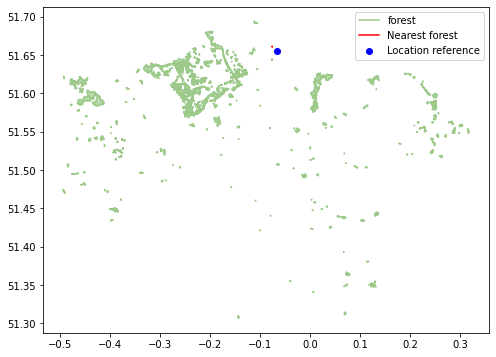

In [8]:
if (use_precomputed_file == False):
    plt.figure(figsize=(8, 6))
    target = targets['forest']
    get_nearest_feature_distance(target['features'].elements(), point, True, target['display_color'], target['column_name'])

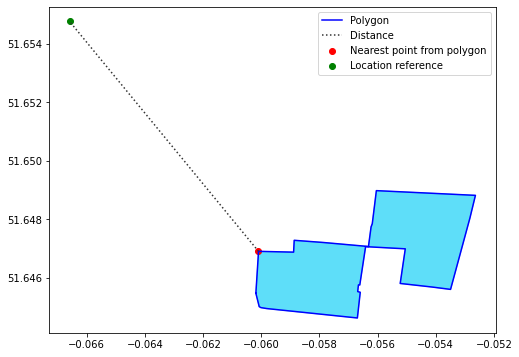

In [9]:
if (use_precomputed_file == False):
    plt.figure(figsize=(8, 6))
    firstElement = targets[next(iter(targets))]['features'].elements()[0]
    get_nearest_point_of_polygon(firstElement.geometry().coordinates[0], point, True, True, '#23D2F8')

[OSMPythonTools.Element] Cannot build geometry: cannot find outer ring for inner ring.
NoneType: None
[OSMPythonTools.Element] Cannot build geometry: cannot find outer ring for inner ring. (relation/2351683)
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/OSMPythonTools/element.py", line 181, in geometry
    polygons = self.__geometry_buildPolygons(ringsOuter, ringsInner)
  File "/usr/local/lib/python3.9/site-packages/OSMPythonTools/element.py", line 276, in __geometry_buildPolygons
    self._raiseException('Cannot build geometry: cannot find outer ring for inner ring.')
  File "/usr/local/lib/python3.9/site-packages/OSMPythonTools/element.py", line 49, in _raiseException
    OSMPythonTools._raiseException('Element', msg)
  File "/usr/local/lib/python3.9/site-packages/OSMPythonTools/__init__.py", line 13, in _raiseException
    raise(Exception(msgComplete))
Exception: [OSMPythonTools.Element] Cannot build geometry: cannot find outer ring for inner ring

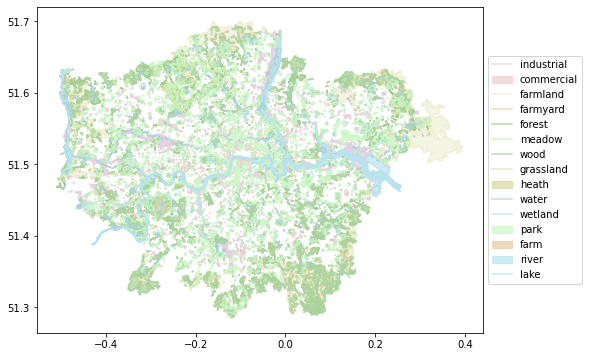

In [10]:
if (use_precomputed_file == False):
    plt.figure(figsize=(8, 6))
    plot_targets(targets)

#### Cyclitisation of time variables

In [20]:
if (use_precomputed_file == False):
    data_enhanced['dayofweek_x'] = data_enhanced.apply(lambda row : linear_to_cyclic_cos(row['date_time_of_call'].day_of_week, 7), axis=1)
    data_enhanced['dayofweek_y'] = data_enhanced.apply(lambda row : linear_to_cyclic_sin(row['date_time_of_call'].day_of_week, 7), axis=1)
    data_enhanced['month_x']     = data_enhanced.apply(lambda row : linear_to_cyclic_cos(row['date_time_of_call'].month, 12), axis=1)
    data_enhanced['month_y']     = data_enhanced.apply(lambda row : linear_to_cyclic_sin(row['date_time_of_call'].month, 12), axis=1)
    data_enhanced['hour_x']      = data_enhanced.apply(lambda row : linear_to_cyclic_cos(row['date_time_of_call'].hour, 24), axis=1)
    data_enhanced['hour_y']      = data_enhanced.apply(lambda row : linear_to_cyclic_sin(row['date_time_of_call'].hour, 24), axis=1)      

## Importing precomputed data

In [5]:
if (use_precomputed_file):
  # Use precomputed cleaned data
  data = pd.read_csv(data_filename, index_col=0)
  data['date_time_of_call'] = pd.to_datetime(data['date_time_of_call'], format='%Y-%m-%d %H:%M:00')

  # Use precomputed cleaned and enhanced data
  data_enhanced = pd.read_csv(enhanced_data_filename, index_col=0)
  data_enhanced['date_time_of_call'] = pd.to_datetime(data_enhanced['date_time_of_call'], format='%Y-%m-%d %H:%M:00')

# Analysis

### Importing librairies and London Borough shapes

In [7]:
# import geoplot as gplt
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import preprocessing

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [16]:
# import london shape
london_borough_shapes = gpd.read_file(r'https://skgrange.github.io/www/data/london_boroughs.json')

### Elementary analysis

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7543 entries, 0 to 7543
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date_time_of_call              7543 non-null   datetime64[ns]
 1   pump_count                     7493 non-null   float64       
 2   incident_notional_cost         7492 non-null   float64       
 3   animal_group_parent            7543 non-null   object        
 4   originof_call                  7543 non-null   object        
 5   property_type                  7543 non-null   object        
 6   property_category              7543 non-null   object        
 7   special_service_type_category  7543 non-null   object        
 8   special_service_type           7543 non-null   object        
 9   borough                        7534 non-null   object        
 10  latitude                       7543 non-null   float64       
 11  longitude        

In [ ]:
data.head(2)

date_time_of_call  pump_count  incident_notional_cost animal_group_parent  \
0 2009-01-01 03:01:00         1.0                   510.0                 dog   
1 2009-01-01 08:51:00         1.0                   255.0                 fox   
2 2009-01-04 10:07:00         1.0                   255.0                 dog   
3 2009-01-05 12:27:00         1.0                   255.0               horse   
4 2009-01-06 15:23:00         1.0                   255.0              rabbit   

        originof_call                                 property_type  \
0  Person (land line)                      House - single occupancy   
1  Person (land line)                                      Railings   
2     Person (mobile)                                 Pipe or drain   
3     Person (mobile)  Intensive Farming Sheds (chickens, pigs etc)   
4     Person (mobile)                      House - single occupancy   

   property_category    special_service_type_category  \
0           Dwelling          Other animal assistance   
1  Outdoor Structure          Other animal assistance   
2  Outdoor Structure  Animal rescue from below ground   
3    Non Residential         Animal rescue from water   
4           Dwelling          Other animal assistance   

                                special_service_type     borough   latitude  \
0  Animal assistance involving livestock - Other ...     Croydon  51.414030   
1  Animal assistance involving livestock - Other ...     Croydon  51.390954   
2     Animal rescue from below ground - Domestic pet      Sutton  51.368941   
3             Animal rescue from water - Farm animal  Hillingdon  51.605283   
4  Animal assistance involving livestock - Other ...    Havering  51.608749   

   longitude  year    month dayofweek  hour  
0  -0.098236  2009  January  Thursday     3  
1  -0.064167  2009  January  Thursday     8  
2  -0.161985  2009  January    Sunday    10  
3  -0.489684  2009  January    Monday    12  
4   0.231963  2009  January   Tuesday    15

In [ ]:
data_enhanced.head(2)

<AxesSubplot:>

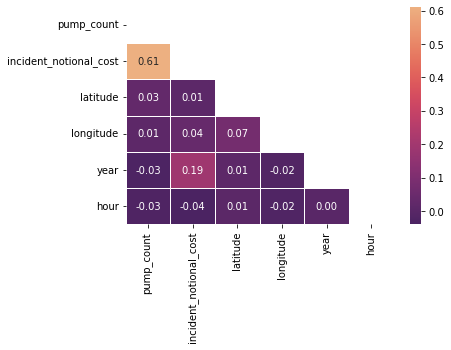

In [162]:
corr = data.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, linewidths=.5, mask=mask, cmap="flare_r", annot=True, fmt=".2f")

<AxesSubplot:>

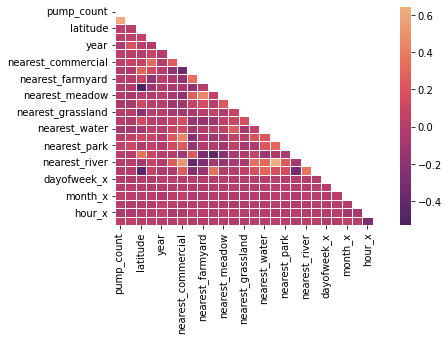

In [164]:
corr = data_enhanced.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, linewidths=.5, mask=mask, cmap="flare_r")

In [ ]:
plt.figure(figsize=(16, 16))
corr = abs(data_enhanced.corr())
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, linewidths=.5, mask=mask, cmap="flare_r", annot=False, fmt=".2f", vmin=0, vmax=1)

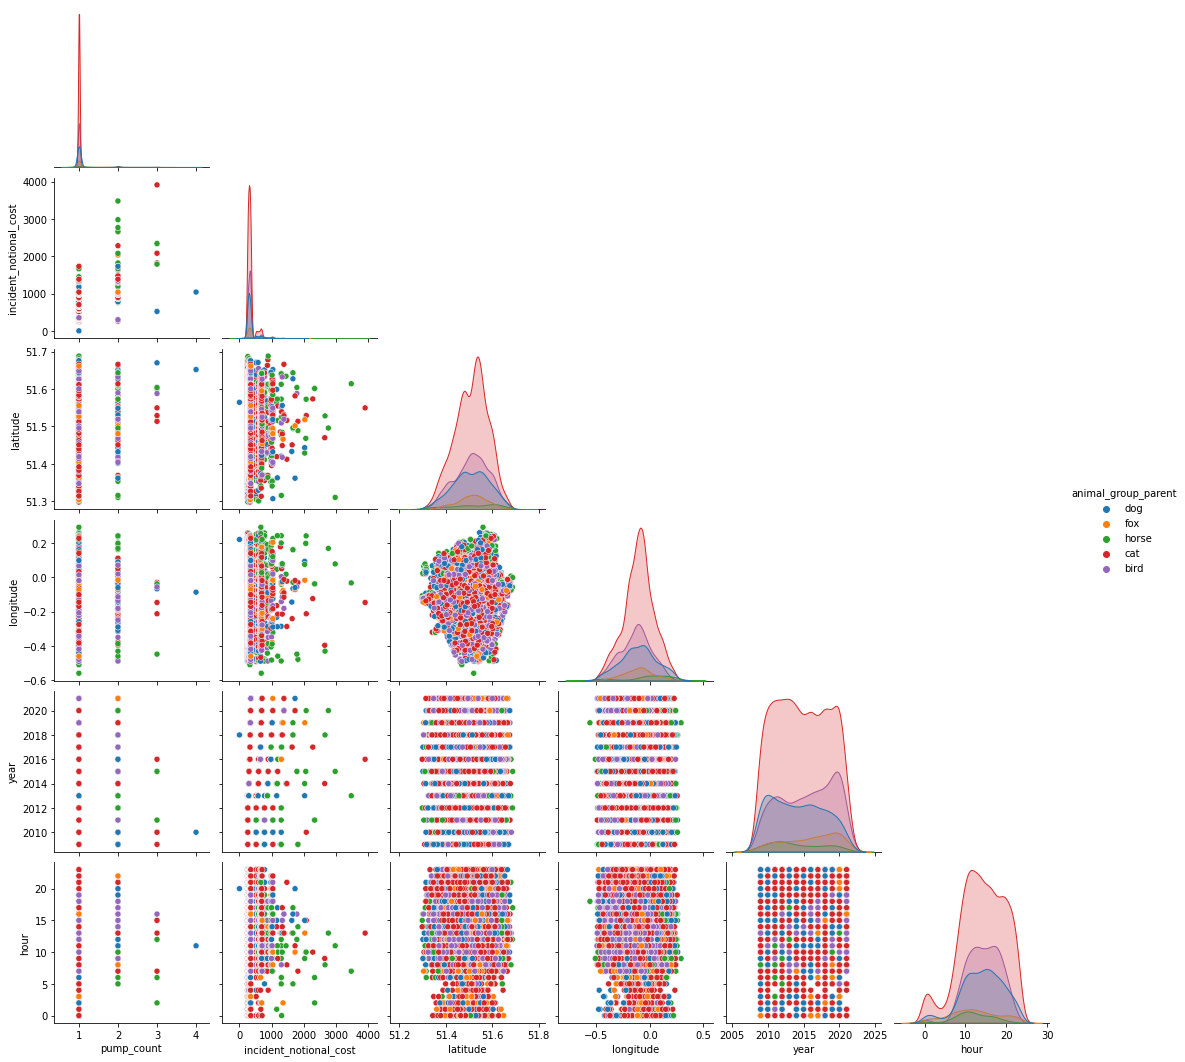

In [ ]:
most_present_animals = data['animal_group_parent'].value_counts()[:5].index.tolist()
df = data[data['animal_group_parent'].isin(most_present_animals)]
sns.pairplot(data=df, hue='animal_group_parent', corner=True)

In [ ]:
object_attributs, numeric_attributs = numeric_categorical_attributs_split(data)
print(f"Numerical variables   : {numeric_attributs}")
print(f"Categorical variables :  {object_attributs}")

## Analysis of some variables

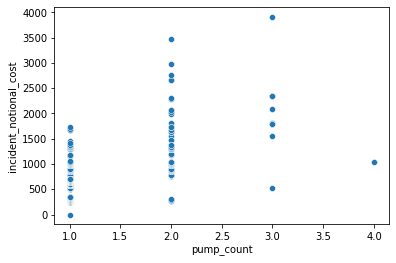

In [ ]:
sns.scatterplot(x="pump_count", y="incident_notional_cost", data=data)

Text(0.5, 0, "Coût total de l'intervention")

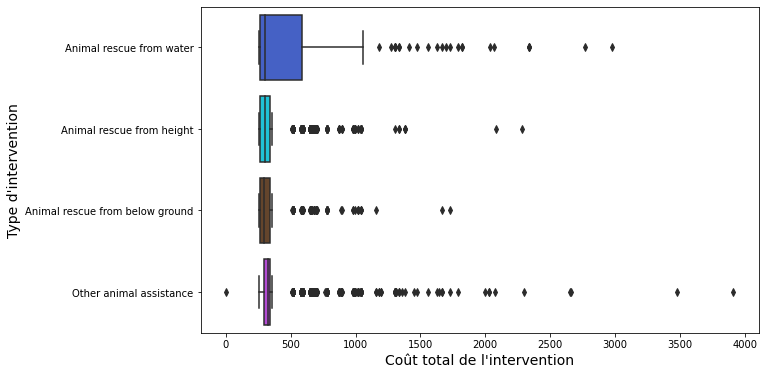

In [ ]:
order = ["Animal rescue from water", "Animal rescue from height", "Animal rescue from below ground", "Other animal assistance"]
my_pal = { "Animal rescue from water": "#3055Da", 
          "Animal rescue from height": "#02d9f5",
          "Animal rescue from below ground": "#6d4423",
          "Other animal assistance": "#c034eb"
          }

fig, ax= plt.subplots(figsize=(10, 6))
boxplot = sns.boxplot(ax=ax, x="incident_notional_cost", y="special_service_type_category", data=data, order=order, palette=my_pal)
boxplot.set_ylabel("Type d'intervention", fontsize=14)
boxplot.set_xlabel("Coût total de l'intervention", fontsize=14)

Text(0, 0.5, "Cout total de l'intervention")

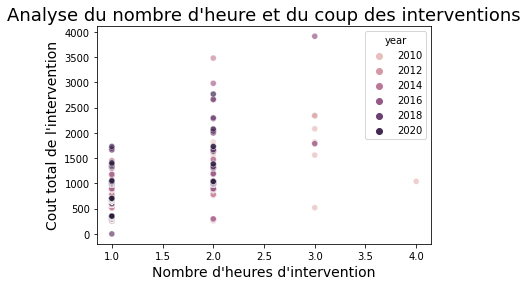

In [ ]:
p = sns.scatterplot(x="pump_count", y="incident_notional_cost", data=data, hue='year', alpha=.7)
p.set_title("Analyse du nombre d'heure et du coup des interventions", fontsize = 18)
p.set_xlabel("Nombre d'heures d'intervention", fontsize = 14)
p.set_ylabel("Cout total de l'intervention", fontsize = 14)

## Spatial analysis

Text(41.25, 0.5, 'Longitude')

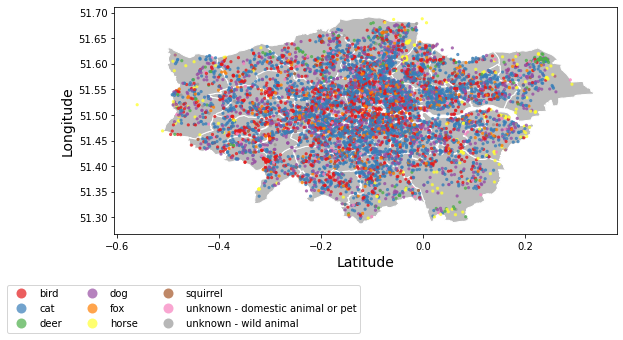

In [22]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
most_present_animals = data['animal_group_parent'].value_counts()[:9].index.tolist()

filtered_data = data[data['animal_group_parent'].isin(most_present_animals)]   
gdf = gpd.GeoDataFrame(filtered_data, geometry=gpd.points_from_xy(filtered_data.longitude, filtered_data.latitude))
london_borough_shapes.plot(ax=ax, edgecolor='#FFF', color='#BBB')
gdf.plot(ax=ax, markersize=5, alpha=.7, cmap="Set1", column='animal_group_parent', legend=True, legend_kwds={'bbox_to_anchor': (0.5, -0.2), 'ncol': 3}) #, column='incident_notional_cost', legend=True
ax.set_xlabel('Latitude', fontsize=14)
ax.set_ylabel('Longitude', fontsize=14)

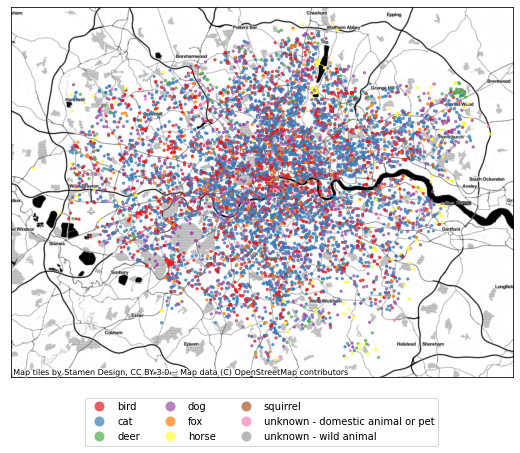

In [127]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
most_present_animals = data['animal_group_parent'].value_counts()[:9].index.tolist()

filtered_data = data[data['animal_group_parent'].isin(most_present_animals)]   
gdf = gpd.GeoDataFrame(filtered_data, geometry=gpd.points_from_xy(filtered_data.longitude, filtered_data.latitude), crs='EPSG:4326')
gdf = gdf.to_crs(epsg=3857) # change to Spherical Mercator to add ctx base map properly
gdf.plot(ax=ax, markersize=5, alpha=.7, cmap="Set1", column='animal_group_parent', legend=True, legend_kwds={'loc':'lower center', 'bbox_to_anchor': (0.5, -0.2), 'ncol': 3})
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax, source=cx.providers.Stamen.Toner)

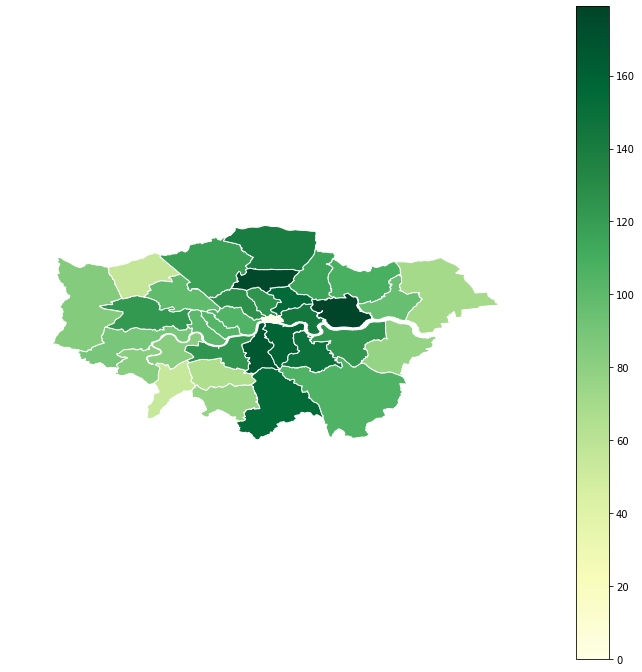

In [ ]:
filtered_data = data[data['animal_group_parent'] == 'cat']
gdf = gpd.GeoDataFrame(filtered_data, geometry=gpd.points_from_xy(filtered_data.longitude, filtered_data.latitude))

pts = gdf.copy() 
pts_in_polys = []
for i, poly in london_borough_shapes.iterrows():
    pts_in_this_poly = []
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])
    pts_in_polys.append(len(pts_in_this_poly))
london_borough_shapes['number of points'] = gpd.GeoSeries(pts_in_polys)

ax = gplt.choropleth( 
                figsize=(12, 12),
                df=london_borough_shapes, 
                edgecolor='#FFF', 
                cmap="YlGn", 
                hue=london_borough_shapes['number of points'], 
                legend=True,
                )

plt.show()


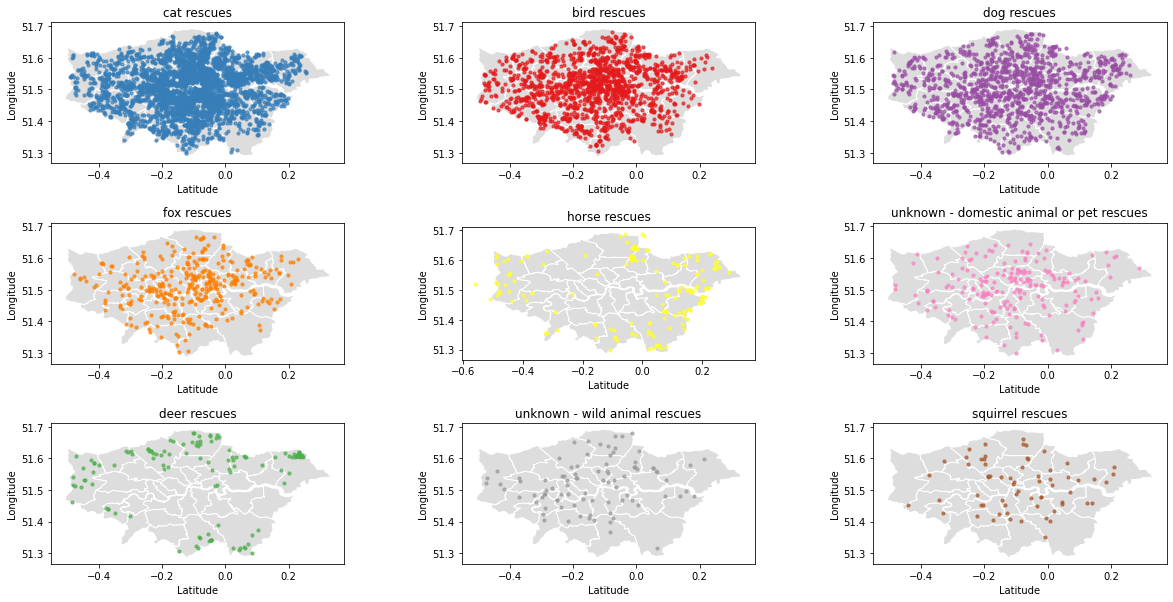

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
most_present_animals = data['animal_group_parent'].value_counts()[:10].index.tolist()
for i in range(1, 10):
  animal = most_present_animals[i-1]
  one_animal_type = data[data['animal_group_parent'] == animal]   
  ax = fig.add_subplot(3, 3, i)
  gdf = gpd.GeoDataFrame(one_animal_type, geometry=gpd.points_from_xy(one_animal_type.longitude, one_animal_type.latitude))
  london_borough_shapes.plot(ax=ax, edgecolor='#FFF', color='#DDD')
  gdf.plot(ax=ax, markersize=10, alpha=.7, color=sns.color_palette("Set1")[animal_index_color_palette[animal]]) #, column='incident_notional_cost', legend=True
  ax.set_xlabel('Latitude', fontsize=10)
  ax.set_ylabel('Longitude', fontsize='medium')
  ax.set_title(f"{animal} rescues")


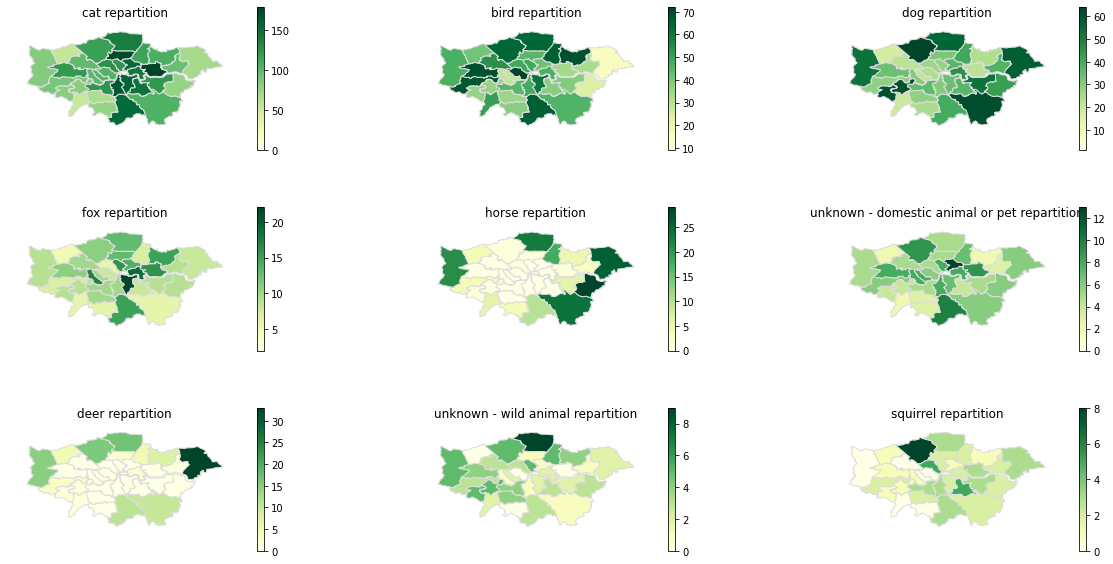

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
most_present_animals = data['animal_group_parent'].value_counts()[:10].index.tolist()
for i in range(1, 10):
  animal = most_present_animals[i-1]
  one_animal_type = data[data['animal_group_parent'] == animal]   
  gdf = gpd.GeoDataFrame(one_animal_type, geometry=gpd.points_from_xy(one_animal_type.longitude, one_animal_type.latitude))

  ax = fig.add_subplot(3, 3, i)
  pts = gdf.copy() 
  pts_in_polys = []
  for i, poly in london_borough_shapes.iterrows():
      pts_in_this_poly = []
      for j, pt in pts.iterrows():
          if poly.geometry.contains(pt.geometry):
              pts_in_this_poly.append(pt.geometry)
              pts = pts.drop([j])
      pts_in_polys.append(len(pts_in_this_poly))
  london_borough_shapes['number of points'] = gpd.GeoSeries(pts_in_polys)

  gplt.choropleth( 
                  ax = ax,
                  figsize=(12, 12),
                  df=london_borough_shapes, 
                  edgecolor='#DDD', 
                  cmap="YlGn", 
                  hue=london_borough_shapes['number of points'], 
                  legend=True,
      )
  ax.set_title(f"{animal} repartition")



## Temporal analysis

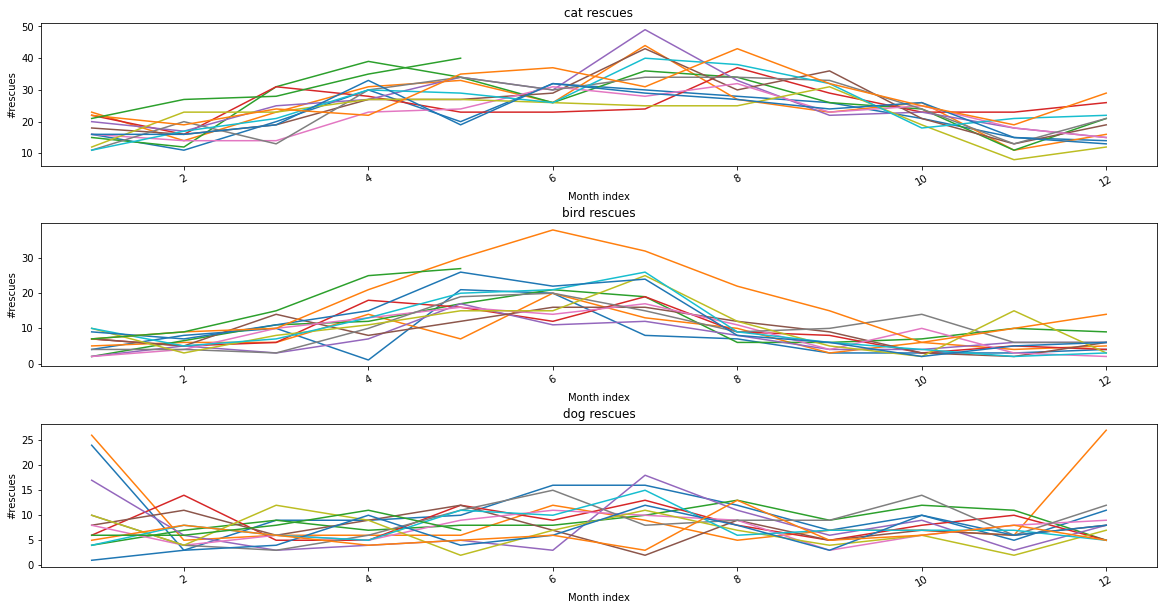

In [24]:
most_present_animals = data['animal_group_parent'].value_counts()[:3].index.tolist()
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
filtered_data = data[data['animal_group_parent'].isin(most_present_animals)]
for i in range(len(most_present_animals)):
    ax = fig.add_subplot(3, 1, i + 1)
    animal = most_present_animals[i]
    df = data[data['animal_group_parent'] == animal]
    for year, df in df.groupby([df['date_time_of_call'].dt.year]):
        df['date_time_of_call'].groupby([df['date_time_of_call'].dt.month]).size().plot(ax=ax, label=year)
    ax.set_xlabel('Month index', fontsize=10)
    ax.set_ylabel('#rescues', fontsize='medium')
    ax.set_title(f"{animal} rescues")
    ax.tick_params(axis='x', labelrotation=30)


[None, None, None, None]

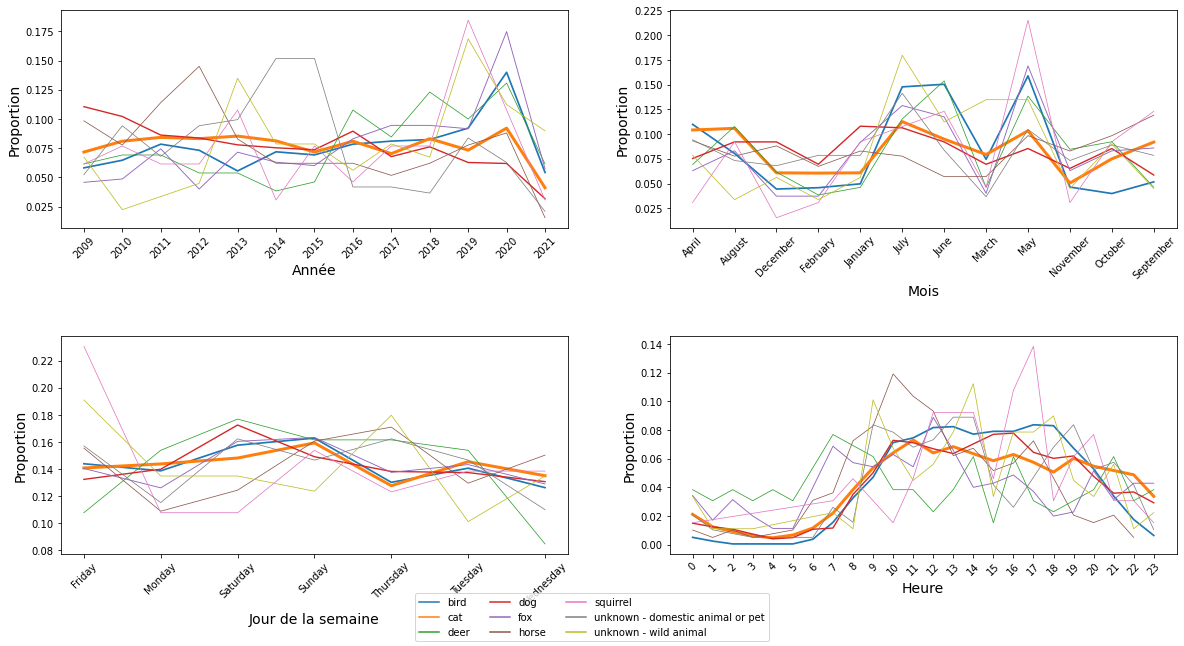

In [25]:
most_present_animals_count = data['animal_group_parent'].value_counts()[:9]

most_present_animals = most_present_animals_count.index.tolist()
filtered_data = data[data['animal_group_parent'].isin(most_present_animals)]
fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
fig.tight_layout()
graphs = ['year', 'month', 'dayofweek', 'hour']

axes_legend = {
    'year': 'Année',
    'month': 'Mois',
    'dayofweek': 'Jour de la semaine',
    'hour': 'Heure',
}

i=0
for column in graphs:
  ax = fig.add_subplot(2, 2, i+1)
  r = filtered_data.groupby([filtered_data[column], filtered_data.animal_group_parent]).size()
  df = r.to_frame()
  df = df.reset_index()
  df['proportional'] = df[0]
  for an in most_present_animals:
    df.loc[df["animal_group_parent"] == an, "count"] = int(math.ceil((most_present_animals_count[an] / most_present_animals_count.sum()) * 30))
    df.loc[df["animal_group_parent"] == an, "proportional"] /= df[df.animal_group_parent == an]['proportional'].sum()
  p = sns.lineplot(data=df, ax=ax, x=column, y='proportional', hue='animal_group_parent', legend=True, size='count')
  p.set_xlabel(axes_legend[column], fontsize = 14)
  p.set_ylabel("Proportion", fontsize = 14)
  plt.xticks(rotation=45)
  if column == 'year':
    plt.xticks(np.arange(2009, 2022, step=1))
  elif column == 'hour':
    plt.xticks(np.arange(0, 24, step=1))
  
  i+=1

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[1:10], labels[1:10], loc='lower center', ncol=3)
[ax.get_legend().remove() for ax in fig.axes]

/var/folders/bl/nnfcy4gs08zdp_gnvvbfv63r0000gp/T/ipykernel_52545/1259089592.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[i])
/var/folders/bl/nnfcy4gs08zdp_gnvvbfv63r0000gp/T/ipykernel_52545/1259089592.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[i])
/var/folders/bl/nnfcy4gs08zdp_gnvvbfv63r0000gp/T/ipykernel_52545/1259089592.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[i])


[None, None, None]

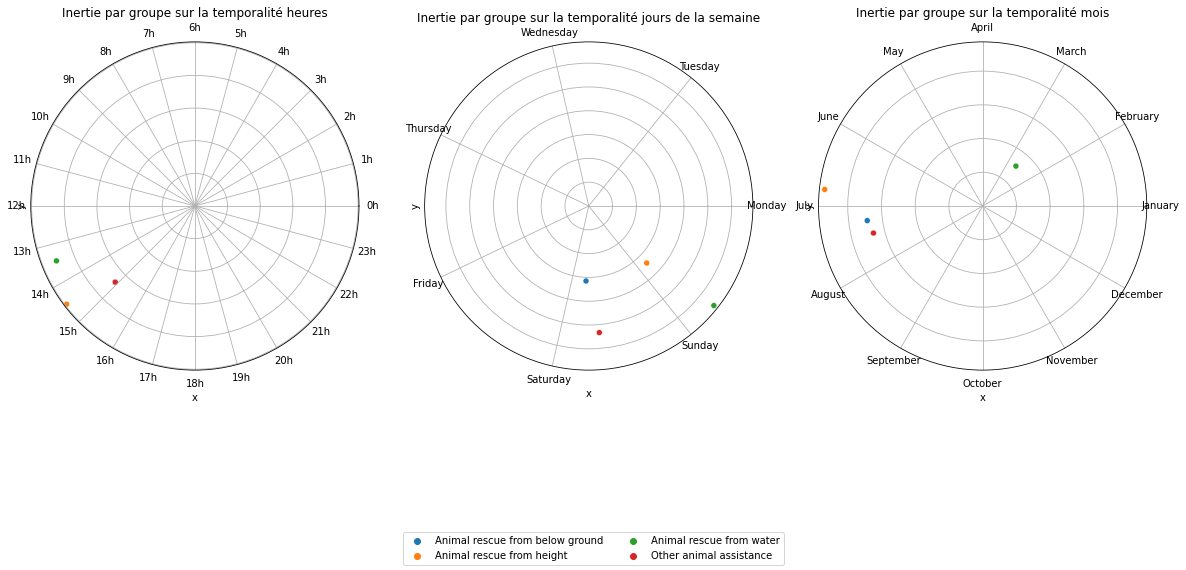

In [28]:
df_dayofweek = pd.DataFrame({'dayofweek': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 'index': [i for i in range(7)]})
df_month = pd.DataFrame({'month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], 'index': [i for i in range(12)]})
df_hour = pd.DataFrame({'hour': [f"{i}h" for i in range(24)], 'index': [i for i in range(24)]})

fig = plt.figure(figsize=(20,10))
ticks = [12, 3.5, 6]
labels = [df_hour.hour, df_dayofweek.dayofweek, df_month.month]
temporalite_labels = ['heures', 'jours de la semaine', 'mois']
for i, tmp in enumerate(['hour', 'dayofweek', 'month']):
  ax = fig.add_subplot(1, 3, i+1, projection='polar')
  ax.set_xticklabels(labels[i])  
  ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/ticks[i]))
  ax.set_rlabel_position(False)
  ax.set_yticklabels([])
  ax.grid(True)
  ax.set_title(f"Inertie par groupe sur la temporalité {temporalite_labels[i]}")
  most_present_animals = data_enhanced['special_service_type_category'].value_counts()[:10].index.tolist()

  filtered_data = data_enhanced[data_enhanced['special_service_type_category'].isin(most_present_animals)].groupby(['special_service_type_category']).mean()
  filtered_data[f"{tmp}_theta"] = filtered_data.apply(lambda row : cyclic_to_theta(row[f"{tmp}_x"], row[f"{tmp}_y"]), axis=1)
  filtered_data[f"{tmp}_radius"] = filtered_data.apply(lambda row : cyclic_to_radius(row[f"{tmp}_x"], row[f"{tmp}_y"]), axis=1)

  filtered_data
  c = sns.scatterplot(ax=ax, data=filtered_data, x=filtered_data[f"{tmp}_theta"], y=filtered_data[f"{tmp}_radius"], alpha=1, hue=filtered_data.index)
  c.set_xlabel('x')
  c.set_ylabel('y')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)
[ax.get_legend().remove() for ax in fig.axes]

/var/folders/bl/nnfcy4gs08zdp_gnvvbfv63r0000gp/T/ipykernel_52545/2801131199.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[i])
/var/folders/bl/nnfcy4gs08zdp_gnvvbfv63r0000gp/T/ipykernel_52545/2801131199.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[i])
/var/folders/bl/nnfcy4gs08zdp_gnvvbfv63r0000gp/T/ipykernel_52545/2801131199.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels[i])


[None, None, None]

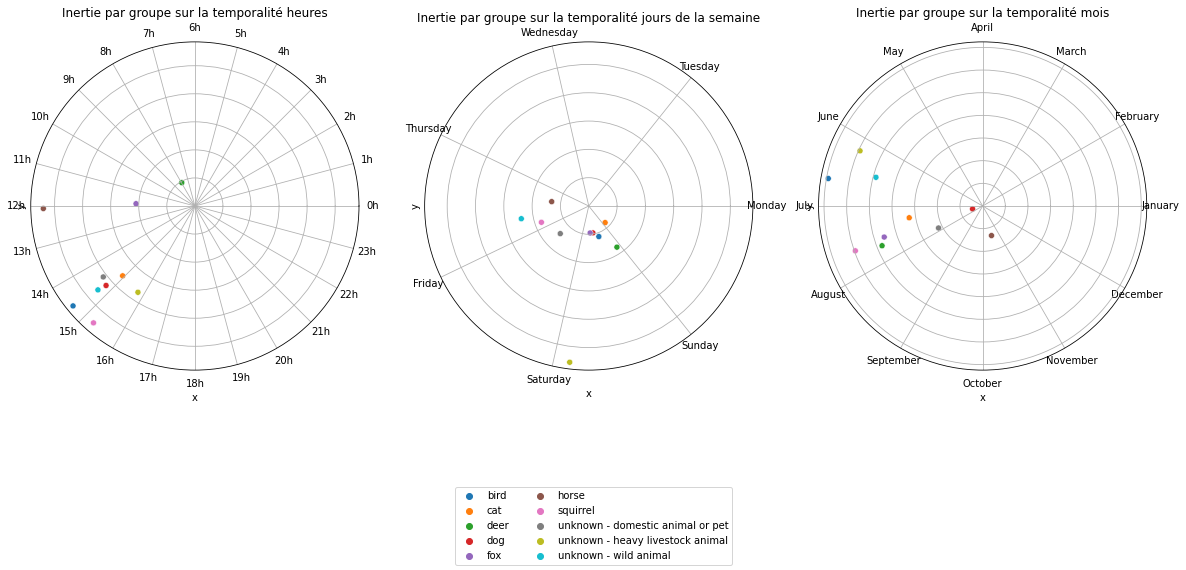

In [29]:
df_dayofweek = pd.DataFrame({'dayofweek': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 'index': [i for i in range(7)]})
df_month = pd.DataFrame({'month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], 'index': [i for i in range(12)]})
df_hour = pd.DataFrame({'hour': [f"{i}h" for i in range(24)], 'index': [i for i in range(24)]})

fig = plt.figure(figsize=(20,10))
ticks = [12, 3.5, 6]
labels = [df_hour.hour, df_dayofweek.dayofweek, df_month.month]
temporalite_labels = ['heures', 'jours de la semaine', 'mois']
for i, tmp in enumerate(['hour', 'dayofweek', 'month']):
  ax = fig.add_subplot(1, 3, i+1, projection='polar')
  ax.set_xticklabels(labels[i])  
  ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/ticks[i]))
  ax.set_rlabel_position(False)
  ax.set_yticklabels([])
  ax.grid(True)
  ax.set_title(f"Inertie par groupe sur la temporalité {temporalite_labels[i]}")
  most_present_animals = data_enhanced['animal_group_parent'].value_counts()[:10].index.tolist()

  filtered_data = data_enhanced[data_enhanced['animal_group_parent'].isin(most_present_animals)].groupby(['animal_group_parent']).mean()
  filtered_data[f"{tmp}_theta"] = filtered_data.apply(lambda row : cyclic_to_theta(row[f"{tmp}_x"], row[f"{tmp}_y"]), axis=1)
  filtered_data[f"{tmp}_radius"] = filtered_data.apply(lambda row : cyclic_to_radius(row[f"{tmp}_x"], row[f"{tmp}_y"]), axis=1)

  filtered_data
  c = sns.scatterplot(ax=ax, data=filtered_data, x=filtered_data[f"{tmp}_theta"], y=filtered_data[f"{tmp}_radius"], alpha=1, hue=filtered_data.index)
  c.set_xlabel('x')
  c.set_ylabel('y')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2)
[ax.get_legend().remove() for ax in fig.axes]

## PCA

Keep only numerical columns, then remove lines with at least one nan value

In [31]:
pca_data = data.copy()
pca_data['month'] = pca_data['date_time_of_call'].dt.month
pca_data['dayofweek'] = pca_data['date_time_of_call'].dt.day_of_week
pca_data = pca_data.dropna()
pca_numeric_data = pca_data._get_numeric_data()
x = pca_numeric_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalised_data = pd.DataFrame(x_scaled)

In [32]:
cls = PCA()
pcs = cls.fit_transform(normalised_data)

In [33]:
cls.explained_variance_ratio_

array([0.27593759, 0.22932632, 0.18781633, 0.1229089 , 0.09268388,
       0.07942218, 0.00972783, 0.00217697])

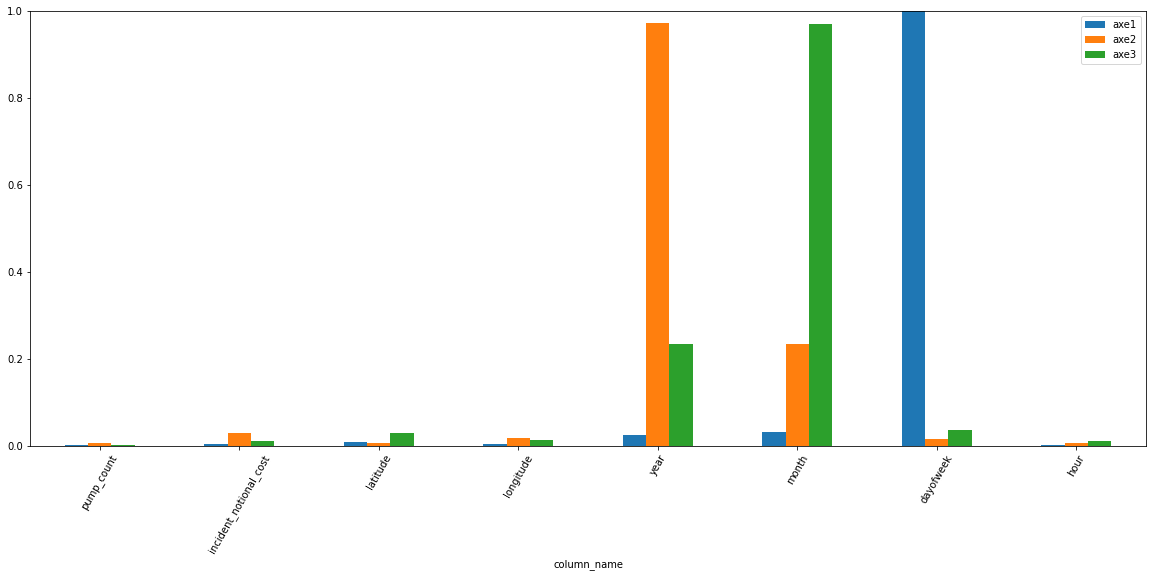

In [34]:
column_importances = pd.DataFrame({ 'column_name': pca_numeric_data.columns, 'axe1': abs(cls.components_[0]), 'axe2': abs(cls.components_[1]), 'axe3': abs(cls.components_[2])  })
ax = column_importances.plot(x="column_name", y=["axe1", "axe2", "axe3"], kind="bar",figsize=(20,8), ylim=(0,1))
for item in ax.get_xticklabels():
    item.set_rotation(60)

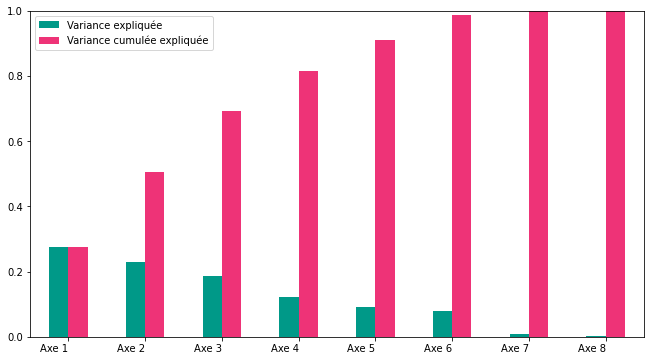

In [35]:
fig, ax1 = plt.subplots(figsize=(11, 6))

names = [f"Axe {i+1}" for i in range (len(cls.explained_variance_ratio_))]
plt.ylim(0, 1)

df = pd.DataFrame(data={
    'Variance expliquée': cls.explained_variance_ratio_,
    'Variance cumulée expliquée': np.cumsum(cls.explained_variance_ratio_)
})
colors= {
    'Variance expliquée': '#009988',
    'Variance cumulée expliquée': '#EE3377'
}
p = df.plot(ax=ax1, y=["Variance expliquée", "Variance cumulée expliquée"], kind="bar", color=colors)
ax1.set_xticklabels([f"Axe {i+1}" for i in range(len(cls.explained_variance_ratio_))], rotation=0, ha='right')
plt.show()


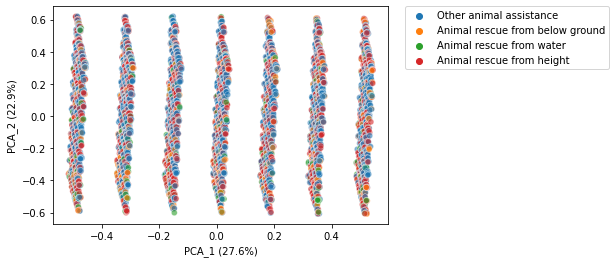

In [36]:
p = sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], data=pca_data, hue="special_service_type_category", cmap='flare', alpha=0.6) # 

p.set_xlabel(f"PCA_1 ({pretty_pct_round(cls.explained_variance_ratio_[0])}%)", fontsize = 10)
p.set_ylabel(f"PCA_2 ({pretty_pct_round(cls.explained_variance_ratio_[1])}%)", fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


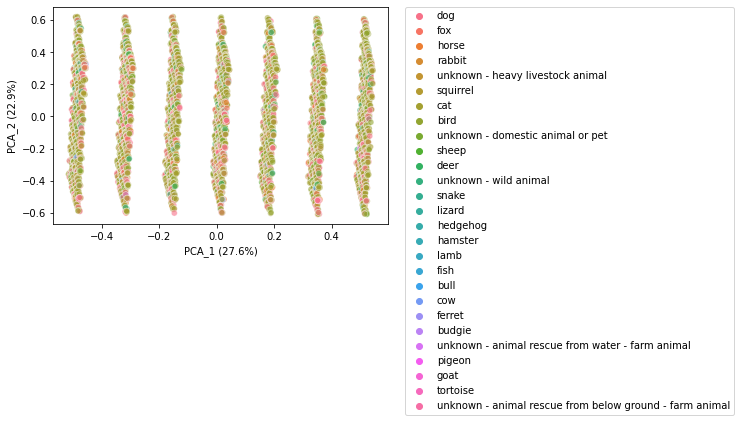

In [37]:
p = sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1], data=pca_data, hue="animal_group_parent", cmap='flare', alpha=0.6) # 

p.set_xlabel(f"PCA_1 ({pretty_pct_round(cls.explained_variance_ratio_[0])}%)", fontsize = 10)
p.set_ylabel(f"PCA_2 ({pretty_pct_round(cls.explained_variance_ratio_[1])}%)", fontsize = 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## K-means clustering

Data : initial, Target : animal_group_parent, Adjusted rand score : 0.005885318557881903
Data : enhanced, Target : animal_group_parent, Adjusted rand score : 0.014299483227119077
Data : initial, Target : special_service_type_category, Adjusted rand score : 0.02470347990314211
Data : enhanced, Target : special_service_type_category, Adjusted rand score : -0.003244607432486376


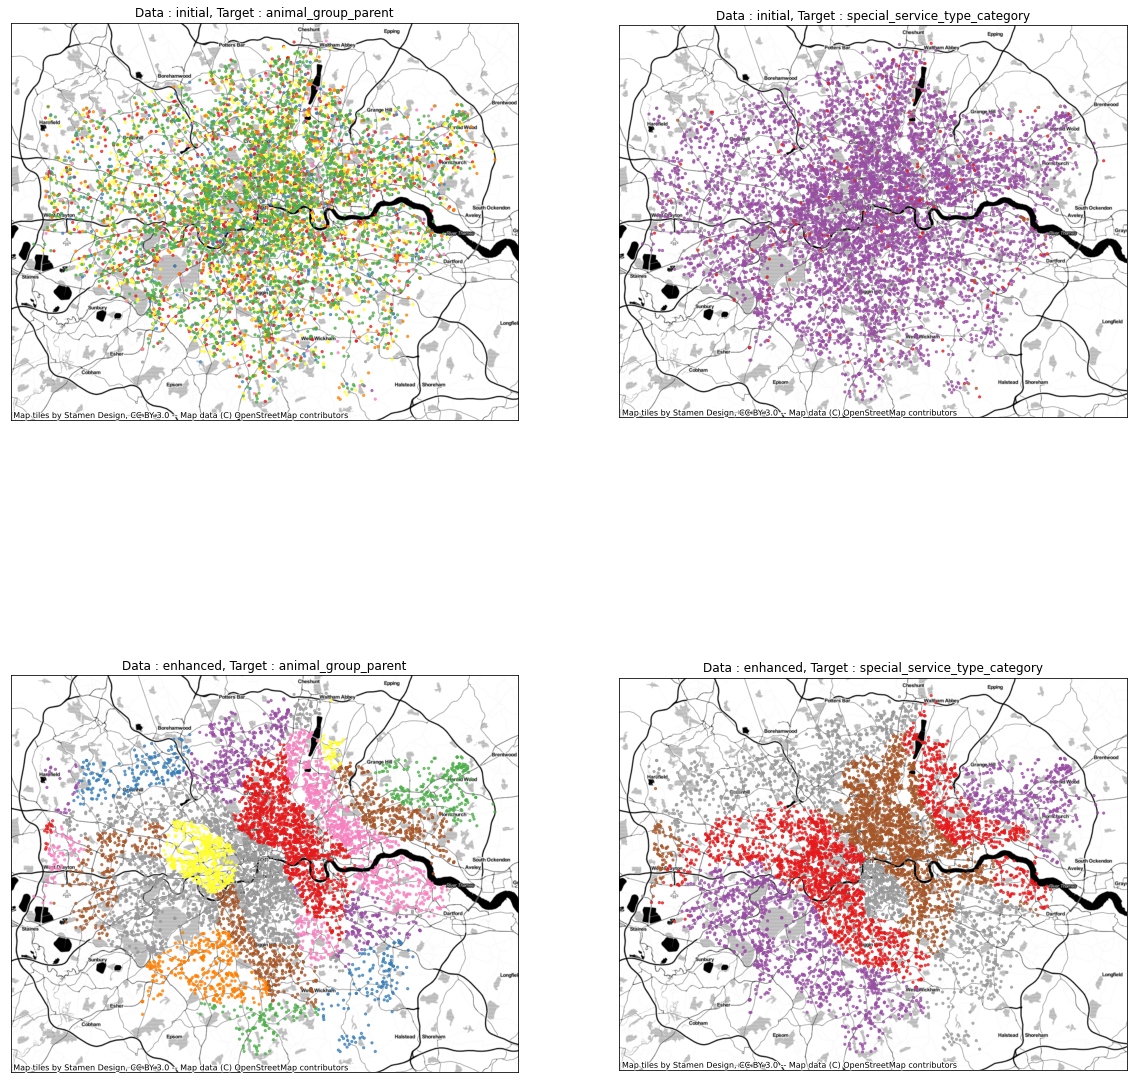

In [32]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
fig.tight_layout()

for i, target in enumerate([(10, 'animal_group_parent'), (4, 'special_service_type_category')]):
    for j, df in enumerate([('initial', data), ('enhanced', data_enhanced)]):
        kmeans_data = df[1].copy()
        most_present_animals = kmeans_data[target[1]].value_counts()[:9].index.tolist()
        kmeans_data =  kmeans_data[kmeans_data[target[1]].isin(most_present_animals)] 
        kmeans_data = kmeans_data.dropna()
        kmeans_numeric_data = kmeans_data._get_numeric_data()
        cls = KMeans(n_clusters=target[0], init="random", random_state=42, n_init=100)
        cls.fit(kmeans_numeric_data)
        print(f"Data : {df[0]}, Target : {target[1]}, Adjusted rand score : {adjusted_rand_score(cls.labels_, kmeans_data[target[1]])}")
        ax =  fig.add_subplot(2, 2, (i+1)+(j)*2)
        gdf = gpd.GeoDataFrame(kmeans_data, geometry=gpd.points_from_xy(kmeans_data.longitude, kmeans_data.latitude), crs='EPSG:4326')
        gdf = gdf.to_crs(epsg=3857) # change to Spherical Mercator to add ctx base map properly
        gdf.plot(ax=ax, markersize=5, alpha=.7, cmap="Set1", column=cls.labels_)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Data : {df[0]}, Target : {target[1]}")
        cx.add_basemap(ax, source=cx.providers.Stamen.Toner)

## Hierarchical Ascending Classification

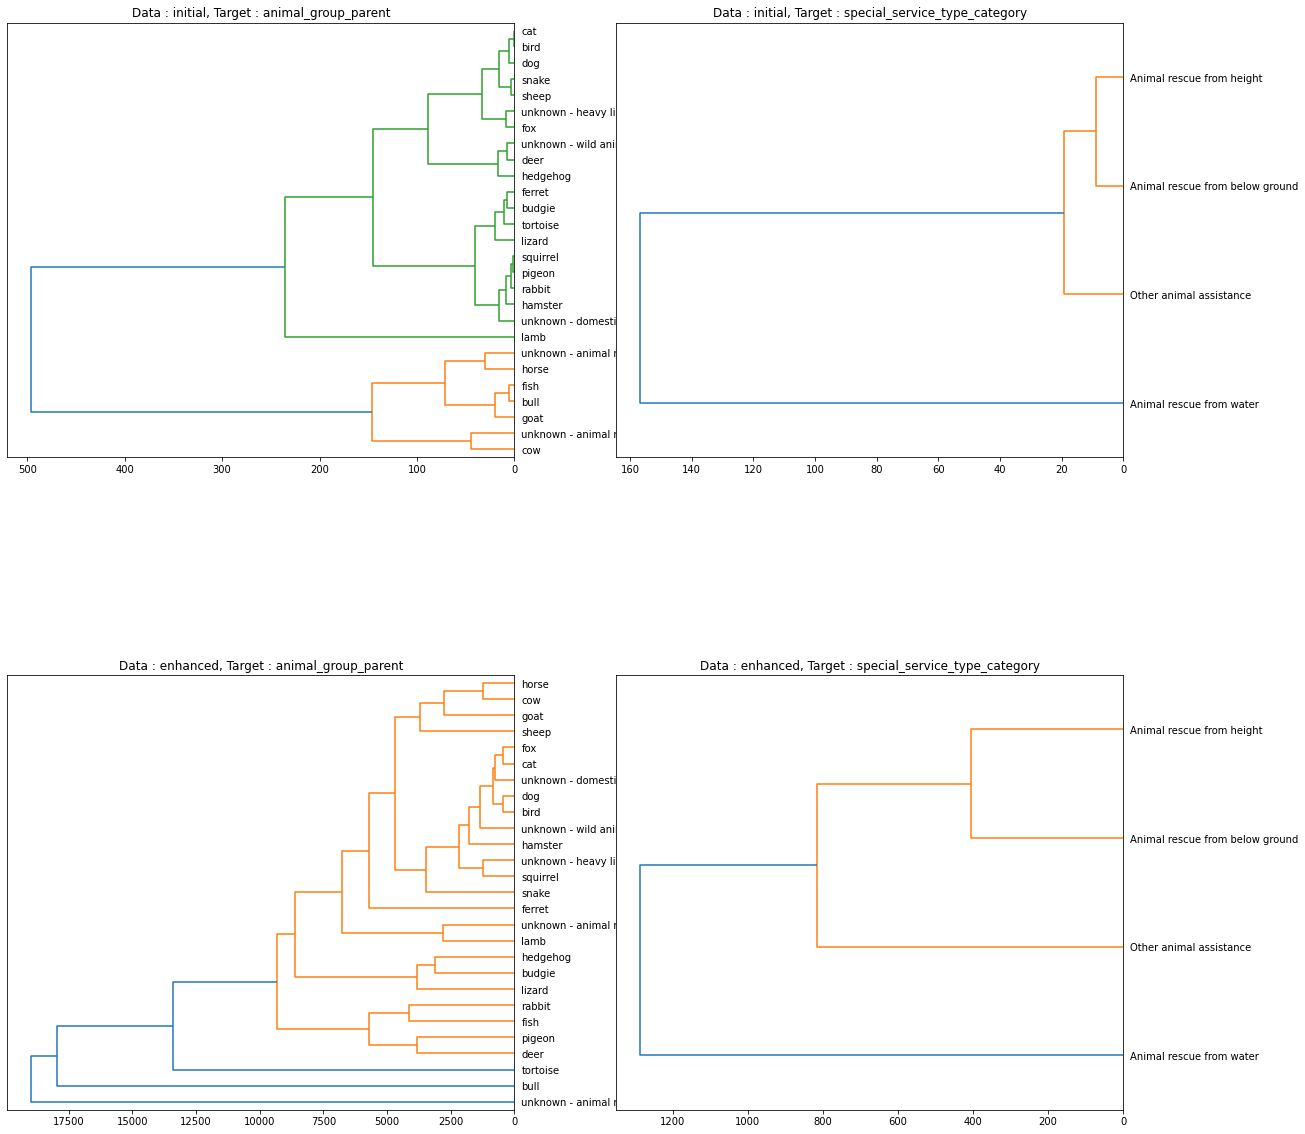

In [31]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
fig.tight_layout()

for i, target in enumerate([(9, 'animal_group_parent'), (4, 'special_service_type_category')]):
    for j, df in enumerate([('initial', data), ('enhanced', data_enhanced)]):
        grouped = df[1].copy().set_index(target[1]).groupby(target[1]).agg('mean')
        ax =  fig.add_subplot(2, 2, (i+1)+(j)*2)
        cls = AgglomerativeClustering(affinity='euclidean', linkage="complete", distance_threshold=0, n_clusters=None)
        cls.fit(grouped._get_numeric_data().dropna())
        plot_dendrogram(cls, ax=ax, labels=grouped.index, orientation='left')
        ax.set_title(f"Data : {df[0]}, Target : {target[1]}")

# Supervised classification

## Data source used to apply methods

In [7]:
data.head(2)

date_time_of_call  pump_count  incident_notional_cost animal_group_parent  \
0 2009-01-01 03:01:00         1.0                   510.0                 dog   
1 2009-01-01 08:51:00         1.0                   255.0                 fox   

        originof_call             property_type  property_category  \
0  Person (land line)  House - single occupancy           Dwelling   
1  Person (land line)                  Railings  Outdoor Structure   

  special_service_type_category  \
0       Other animal assistance   
1       Other animal assistance   

                                special_service_type  borough   latitude  \
0  Animal assistance involving livestock - Other ...  Croydon  51.414030   
1  Animal assistance involving livestock - Other ...  Croydon  51.390954   

   longitude  year    month dayofweek  hour  
0  -0.098236  2009  January  Thursday     3  
1  -0.064167  2009  January  Thursday     8

In [7]:
data_enhanced.head(2)

date_time_of_call  pump_count  incident_notional_cost animal_group_parent  \
0 2009-01-01 03:01:00         1.0                   510.0                 dog   
1 2009-01-01 08:51:00         1.0                   255.0                 fox   

        originof_call             property_type  property_category  \
0  Person (land line)  House - single occupancy           Dwelling   
1  Person (land line)                  Railings  Outdoor Structure   

  special_service_type_category  \
0       Other animal assistance   
1       Other animal assistance   

                                special_service_type  borough  ...  \
0  Animal assistance involving livestock - Other ...  Croydon  ...   
1  Animal assistance involving livestock - Other ...  Croydon  ...   

   nearest_park  nearest_farm  nearest_river  nearest_lake  dayofweek_x  \
0    448.080156  10099.969513    5613.157877   3424.924966    -0.900969   
1    252.280363   9577.216474    5528.088204   1139.865797    -0.900969   

   dayofweek_y   month_x  month_y    hour_x    hour_y  
0     0.433884  0.866025      0.5  0.707107  0.707107  
1     0.433884  0.866025      0.5 -0.500000  0.866025  

[2 rows x 34 columns]

In [40]:
data['special_service_type'].value_counts()

Animal rescue from height - Domestic pet                      1689
Assist trapped domestic animal                                1552
Animal rescue from height - Bird                               942
Animal assistance involving livestock - Other action           635
Assist trapped wild animal                                     629
Animal rescue from below ground - Domestic pet                 610
Animal assistance involving domestic animal - Other action     433
Animal rescue from water - Domestic pet                        236
Animal assistance involving wild animal - Other action         143
Wild animal rescue from height                                  87
Animal harm involving domestic animal                           81
Wild animal rescue from below ground                            77
Animal rescue from below ground - Bird                          70
Animal assistance - Lift heavy livestock animal                 62
Animal rescue from water - Farm animal                        

In [34]:
most_present_animals = data['animal_group_parent'].value_counts()[:10].index.tolist()
data = data[data['animal_group_parent'].isin(most_present_animals)]
data_enhanced = data_enhanced[data_enhanced['animal_group_parent'].isin(most_present_animals)]
######## Selection target for classification 
data['animal_group_parent'].value_counts()

cat                                 3666
bird                                1529
dog                                 1194
fox                                  349
horse                                193
unknown - domestic animal or pet     191
deer                                 130
unknown - wild animal                 89
squirrel                              65
unknown - heavy livestock animal      49
Name: animal_group_parent, dtype: int64

In [35]:
data['special_service_type_category'].value_counts()

Other animal assistance            3595
Animal rescue from height          2715
Animal rescue from below ground     757
Animal rescue from water            388
Name: special_service_type_category, dtype: int64

## Importing librairies

In [36]:
from fast_ml.model_development import train_valid_test_split

## Prepare the Data for supervised classification algorithms


### Create a train/validation/test Set


In [37]:
# Definition des targets

target1 = 'animal_group_parent'
target2 = 'special_service_type_category'

targets = [target1, target2]

In [38]:
# Definition of dataframes

dataframe1 = (data, 'initial')
dataframe2 = (data_enhanced, 'enhanced')

dataframes = [dataframe1, dataframe2]

In [39]:
classification_data = dict()

for target in targets:
  classification_data[target] = dict()
  for dataframe in dataframes:
    classification_data[target][dataframe[1]] = {'X_train': None, 'y_train': None, 'X_val': None, 'y_val': None, 'X_test': None, 'y_test': None, 'main_data': None,
                                                 'X_train_oe': None, 'X_val_oe': None, 'X_test_oe': None, 'X_train_ohe': None, 'X_val_ohe': None, 'X_test_ohe': None,
                                                'y_train_enc': None, 'y_val_enc': None, 'y_test_enc': None
                                                 }
    classification_data[target][dataframe[1]]['main_data'] = dataframe[0].copy()
    classification_data[target][dataframe[1]]['main_data'].dropna(inplace = True)
    classification_data[target][dataframe[1]]['main_data'] = delete_feature(classification_data[target][dataframe[1]]['main_data'], 'property_type') 
    classification_data[target][dataframe[1]]['main_data'] = delete_feature(classification_data[target][dataframe[1]]['main_data'], 'date_time_of_call') 
    classification_data[target][dataframe[1]]['main_data'] = delete_feature(classification_data[target][dataframe[1]]['main_data'], 'special_service_type') 


    X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(classification_data[target][dataframe[1]]['main_data'], target = target, train_size=0.8, valid_size=0.1, test_size=0.1, random_state=27)
    classification_data[target][dataframe[1]]['X_train'] = X_train
    classification_data[target][dataframe[1]]['y_train'] = y_train
    classification_data[target][dataframe[1]]['X_val']   = X_val
    classification_data[target][dataframe[1]]['y_val']   = y_val
    classification_data[target][dataframe[1]]['X_test']  = X_test
    classification_data[target][dataframe[1]]['y_test']  = y_test

    ### choose type of target
    s = (classification_data[target][dataframe[1]]['main_data'].dtypes == 'object')
    object_cols = list(s[s].index)

    s1 = (classification_data[target][dataframe[1]]['main_data'].dtypes == 'category')
    catego_cols = list(s1[s1].index)

    cols = catego_cols + object_cols

    # delete col target
    cols.remove(target)

    # # prepare input data
    X_train_oe, X_val_oe, X_test_oe = prepare_inputs_oe(classification_data[target][dataframe[1]]['main_data'].drop(columns=[target]), classification_data[target][dataframe[1]]['X_train'],  classification_data[target][dataframe[1]]['X_test'], classification_data[target][dataframe[1]]['X_val'],  cols)
    classification_data[target][dataframe[1]]['X_train_oe'] = X_train_oe
    classification_data[target][dataframe[1]]['X_val_oe']   = X_val_oe
    classification_data[target][dataframe[1]]['X_test_oe']  = X_test_oe

    X_train_ohe, X_val_ohe, X_test_ohe = prepare_inputs_ohe(classification_data[target][dataframe[1]]['main_data'].drop(columns=[target]), classification_data[target][dataframe[1]]['X_train'], classification_data[target][dataframe[1]]['X_test'], classification_data[target][dataframe[1]]['X_val'],  cols)
    classification_data[target][dataframe[1]]['X_train_ohe'] = X_train_ohe
    classification_data[target][dataframe[1]]['X_val_ohe']   = X_val_ohe
    classification_data[target][dataframe[1]]['X_test_ohe']  = X_test_ohe

    # # prepare output data
    y_train_enc, y_val_enc, y_test_enc = prepare_targets(classification_data[target][dataframe[1]]['main_data'][target], classification_data[target][dataframe[1]]['y_train'], classification_data[target][dataframe[1]]['y_val'],  classification_data[target][dataframe[1]]['y_test'])
    classification_data[target][dataframe[1]]['y_train_enc'] = y_train_enc
    classification_data[target][dataframe[1]]['y_val_enc']   = y_val_enc
    classification_data[target][dataframe[1]]['y_test_enc']  = y_test_enc


In [13]:
classification_data[target1][dataframe2[1]]['X_train_oe'].head(2)

pump_count  incident_notional_cost  originof_call  property_category  \
4387         2.0                   978.0              2                  4   
3990         1.0                   298.0              2                  4   

      special_service_type_category  borough   latitude  longitude  year  \
4387                              3       39  51.461495  -0.195051  2016   
3990                              3       40  51.508879  -0.029730  2015   

      nearest_industrial  ...  nearest_park  nearest_farm  nearest_river  \
4387           30.427181  ...     17.988224   7397.851087       0.000000   
3990          207.218755  ...     86.206642  17619.344701     161.298564   

      nearest_lake  dayofweek_x  dayofweek_y       month_x       month_y  \
4387   2905.505957    -0.900969     0.433884 -1.000000e+00  1.224647e-16   
3990   1402.403236    -0.222521    -0.974928 -1.836970e-16 -1.000000e+00   

        hour_x    hour_y  
4387  0.258819 -0.965926  
3990 -0.500000 -0.866025  

[2 rows x 30 columns]

In [14]:
classification_data[target1][dataframe2[1]]['X_train_ohe'].head(2)

pump_count  incident_notional_cost  originof_call_1  originof_call_2  \
4387         2.0                   978.0                0                1   
3990         1.0                   298.0                0                1   

      originof_call_3  originof_call_4  originof_call_5  originof_call_6  \
4387                0                0                0                0   
3990                0                0                0                0   

      originof_call_7  originof_call_8  ...  nearest_park  nearest_farm  \
4387                0                0  ...     17.988224   7397.851087   
3990                0                0  ...     86.206642  17619.344701   

      nearest_river  nearest_lake  dayofweek_x  dayofweek_y       month_x  \
4387       0.000000   2905.505957    -0.900969     0.433884 -1.000000e+00   
3990     161.298564   1402.403236    -0.222521    -0.974928 -1.836970e-16   

           month_y    hour_x    hour_y  
4387  1.224647e-16  0.258819 -0.965926  
3990 -1.000000e+00 -0.500000 -0.866025  

[2 rows x 114 columns]

In [15]:
classification_data[target][dataframe[1]]['y_train_enc'][:2]

array([2, 2])

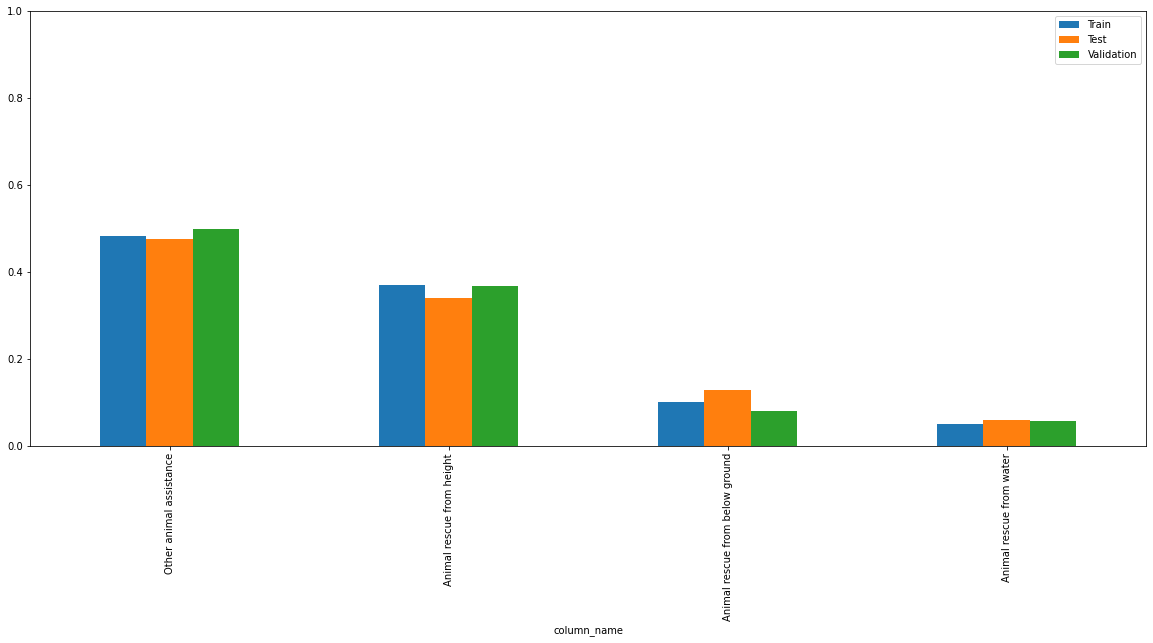

In [16]:
distribution = pd.DataFrame({ 
  'column_name': classification_data[target2][dataframes[0][1]]['y_train'].value_counts().index, 
  'Train': classification_data[target2][dataframes[0][1]]['y_train'].value_counts().values / classification_data[target2][dataframes[0][1]]['y_train'].shape, 
  'Test': classification_data[target2][dataframes[0][1]]['y_test'].value_counts().values / classification_data[target2][dataframes[0][1]]['y_test'].shape, 
  'Validation': classification_data[target2][dataframes[0][1]]['y_val'].value_counts().values / classification_data[target2][dataframes[0][1]]['y_val'].shape
})
ax = distribution.plot(x="column_name", y=["Train", "Test", "Validation"], kind="bar",figsize=(20,8), ylim=(0,1))

## Feature selection

In [17]:

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

selector = RFE(LogisticRegression())
selector = selector.fit(classification_data[target2][dataframe[1]]['X_test_ohe'], classification_data[target2][dataframe[1]]['y_test_enc'])
ranks = pd.DataFrame({ 'column': classification_data[target2][dataframe[1]]['X_test_ohe'].columns, 'rank': selector.ranking_ })

In [18]:
classification_data[target2][dataframe[1]]['X_train_ohe'].loc[:, selector.support_]

pump_count  incident_notional_cost  animal_group_parent_1  \
4387         2.0                   978.0                      0   
3990         1.0                   298.0                      0   
4999         1.0                   328.0                      0   
1845         1.0                   260.0                      0   
3401         1.0                   295.0                      0   
...          ...                     ...                    ...   
4937         1.0                   328.0                      0   
6820         1.0                   346.0                      0   
3985         1.0                   298.0                      0   
3839         1.0                   298.0                      0   
5231         1.0                   328.0                      0   

      animal_group_parent_2  animal_group_parent_3  animal_group_parent_4  \
4387                      1                      0                      0   
3990                      0                      0                      0   
4999                      0                      0                      0   
1845                      0                      0                      0   
3401                      0                      0                      0   
...                     ...                    ...                    ...   
4937                      0                      0                      0   
6820                      0                      0                      0   
3985                      0                      0                      0   
3839                      0                      0                      0   
5231                      0                      0                      0   

      animal_group_parent_6  animal_group_parent_7  animal_group_parent_8  \
4387                      0                      0                      0   
3990                      1                      0                      0   
4999                      0                      1                      0   
1845                      1                      0                      0   
3401                      1                      0                      0   
...                     ...                    ...                    ...   
4937                      0                      1                      0   
6820                      0                      1                      0   
3985                      1                      0                      0   
3839                      1                      0                      0   
5231                      1                      0                      0   

      animal_group_parent_9  ...  nearest_park  nearest_farm  nearest_river  \
4387                      0  ...     17.988224   7397.851087       0.000000   
3990                      0  ...     86.206642  17619.344701     161.298564   
4999                      0  ...    284.082121  10534.421910    2088.384498   
1845                      0  ...    235.500147  12280.179752    1966.100585   
3401                      0  ...     89.776349   8754.302816    3605.225605   
...                     ...  ...           ...           ...            ...   
4937                      0  ...    295.830800  16441.502791    1453.996992   
6820                      0  ...     83.552587  12560.887766    1320.882519   
3985                      0  ...     71.574068  19854.283535    2884.322098   
3839                      0  ...    155.641332   8201.366988    1892.005424   
5231                      0  ...     89.847072  16099.502668    3150.282697   

      nearest_lake  dayofweek_x  dayofweek_y       month_x       month_y  \
4387   2905.505957    -0.900969     0.433884 -1.000000e+00  1.224647e-16   
3990   1402.403236    -0.222521    -0.974928 -1.836970e-16 -1.000000e+00   
4999   3799.063464    -0.222521    -0.974928 -8.660254e-01 -5.000000e-01   
1845   3993.132664    -0.222521    -0.974928  5.000000e-01  8.660254e-01   
3401    972.535226    

In [19]:
dataframes.append((data, 'selected_features'))

for target in targets:
  classification_data[target]['selected_features'] = {'X_train': None, 'y_train': None, 'X_val': None, 'y_val': None, 'X_test': None, 'y_test': None, 'main_data': None,
                                                'X_train_oe': None, 'X_val_oe': None, 'X_test_oe': None, 'X_train_ohe': None, 'X_val_ohe': None, 'X_test_ohe': None,
                                              'y_train_enc': None, 'y_val_enc': None, 'y_test_enc': None
                                                }
  classification_data[target]['selected_features']['main_data'] = classification_data[target]['enhanced']['main_data'].copy()

  selector_ohe = RFE(LogisticRegression())
  selector_ohe = selector_ohe.fit(classification_data[target]['enhanced']['X_test_ohe'], classification_data[target]['enhanced']['y_test_enc']) 
  selector_oe = RFE(LogisticRegression())
  selector_oe = selector_oe.fit(classification_data[target]['enhanced']['X_test_oe'], classification_data[target]['enhanced']['y_test_enc']) 

  classification_data[target]['selected_features']['X_train'] = classification_data[target]['enhanced']['X_train'].copy()
  classification_data[target]['selected_features']['y_train'] = classification_data[target]['enhanced']['y_train'].copy()
  classification_data[target]['selected_features']['X_val']   = classification_data[target]['enhanced']['X_val'].copy()
  classification_data[target]['selected_features']['y_val']   = classification_data[target]['enhanced']['y_val'].copy()
  classification_data[target]['selected_features']['X_test']  = classification_data[target]['enhanced']['X_test'].copy()
  classification_data[target]['selected_features']['y_test']  = classification_data[target]['enhanced']['y_test'].copy()

  # # prepare input data
  classification_data[target]['selected_features']['X_train_oe'] = classification_data[target]['enhanced']['X_train_oe'].copy().loc[:, selector_oe.support_]
  classification_data[target]['selected_features']['X_val_oe']   = classification_data[target]['enhanced']['X_val_oe'].copy().loc[:, selector_oe.support_]
  classification_data[target]['selected_features']['X_test_oe']  = classification_data[target]['enhanced']['X_test_oe'].copy().loc[:, selector_oe.support_]

  classification_data[target]['selected_features']['X_train_ohe'] = classification_data[target]['enhanced']['X_train_ohe'].copy().loc[:, selector_ohe.support_]
  classification_data[target]['selected_features']['X_val_ohe']   = classification_data[target]['enhanced']['X_val_ohe'].copy().loc[:, selector_ohe.support_]
  classification_data[target]['selected_features']['X_test_ohe']  = classification_data[target]['enhanced']['X_test_ohe'].copy().loc[:, selector_ohe.support_]

  # # prepare output data
  classification_data[target]['selected_features']['y_train_enc'] = classification_data[target]['enhanced']['y_train_enc'].copy()
  classification_data[target]['selected_features']['y_val_enc']   = classification_data[target]['enhanced']['y_val_enc'].copy()
  classification_data[target]['selected_features']['y_test_enc']  = classification_data[target]['enhanced']['y_test_enc'].copy()


In [20]:
classification_data[target1]['selected_features']['X_train_ohe'].head(2)

pump_count  incident_notional_cost  originof_call_1  originof_call_2  \
4387         2.0                   978.0                0                1   
3990         1.0                   298.0                0                1   

      originof_call_4  property_category_1  property_category_2  \
4387                0                    0                    0   
3990                0                    0                    0   

      property_category_3  property_category_4  property_category_5  ...  \
4387                    0                    1                    0  ...   
3990                    0                    1                    0  ...   

      nearest_park  nearest_farm  nearest_river  nearest_lake  dayofweek_x  \
4387     17.988224   7397.851087       0.000000   2905.505957    -0.900969   
3990     86.206642  17619.344701     161.298564   1402.403236    -0.222521   

      dayofweek_y       month_x       month_y    hour_x    hour_y  
4387     0.433884 -1.000000e+00  1.224647e-16  0.258819 -0.965926  
3990    -0.974928 -1.836970e-16 -1.000000e+00 -0.500000 -0.866025  

[2 rows x 57 columns]

In [21]:
classification_data[target1]['enhanced']['X_train_ohe'].head(2)

pump_count  incident_notional_cost  originof_call_1  originof_call_2  \
4387         2.0                   978.0                0                1   
3990         1.0                   298.0                0                1   

      originof_call_3  originof_call_4  originof_call_5  originof_call_6  \
4387                0                0                0                0   
3990                0                0                0                0   

      originof_call_7  originof_call_8  ...  nearest_park  nearest_farm  \
4387                0                0  ...     17.988224   7397.851087   
3990                0                0  ...     86.206642  17619.344701   

      nearest_river  nearest_lake  dayofweek_x  dayofweek_y       month_x  \
4387       0.000000   2905.505957    -0.900969     0.433884 -1.000000e+00   
3990     161.298564   1402.403236    -0.222521    -0.974928 -1.836970e-16   

           month_y    hour_x    hour_y  
4387  1.224647e-16  0.258819 -0.965926  
3990 -1.000000e+00 -0.500000 -0.866025  

[2 rows x 114 columns]

## Training and Evaluating on the Training Set


### Choosing model

Model Comparison Methodology:
To begin with, we created a 10-CV cross-validation function to compare the results of different classification models. The purpose of this is to evaluate the accuracy of our model on several test subsets and then to average them and thus obtain more reliable results. We have adapted it to the different models tested.

In [22]:
model_results = pd.DataFrame()

#### KNN

In [23]:
### Import useful library 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB

import seaborn as sns

##### Selection the best hyper-parameters 

We use the GridSearchCV class of the module sklearn.model_selection.

In [24]:
for target in targets:
  for dataframe in dataframes:
    n_neighbors_list = range(1, 200)
    param_grid = {"n_neighbors": n_neighbors_list}
    cls = KNeighborsClassifier()
    search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)

    X_val_ohe = classification_data[target][dataframe[1]]['X_val_ohe']
    y_val = classification_data[target][dataframe[1]]['y_val']

    search.fit(X_val_ohe, y_val)
    classification_data[target][dataframe[1]]['knn_optimal_n'] = search.best_params_['n_neighbors']
    print(f"Target: {target} \t\tData: {dataframe[1]} \tn = {search.best_params_}")


Target: animal_group_parent 		Data: initial 	n = {'n_neighbors': 33}
Target: animal_group_parent 		Data: enhanced 	n = {'n_neighbors': 26}
Target: animal_group_parent 		Data: selected_features 	n = {'n_neighbors': 26}
Target: special_service_type_category 		Data: initial 	n = {'n_neighbors': 115}
Target: special_service_type_category 		Data: enhanced 	n = {'n_neighbors': 108}
Target: special_service_type_category 		Data: selected_features 	n = {'n_neighbors': 108}


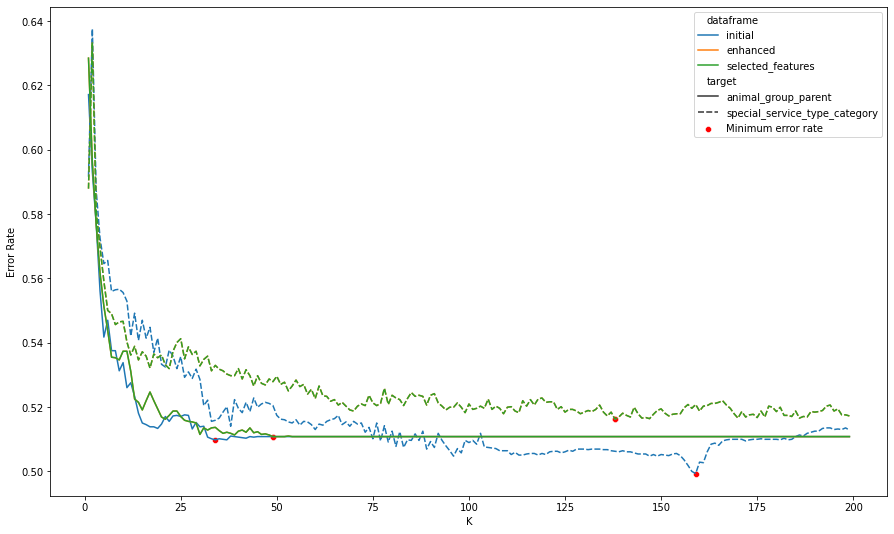

In [25]:

plt.figure(figsize=(15,9))

errors_rates = pd.DataFrame()
minimums = pd.DataFrame()

for target in targets:
     for dataframe in dataframes:
          n_neighbors_list = range(1,200)
          param_grid = {"n_neighbors": n_neighbors_list}
          cls = KNeighborsClassifier()
          search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)

          X_train_ohe = classification_data[target][dataframe[1]]['X_train_ohe']
          X_val_ohe = classification_data[target][dataframe[1]]['X_val_ohe']
          y_train = classification_data[target][dataframe[1]]['y_train']
          y_val = classification_data[target][dataframe[1]]['y_val']
          error_rate = []

          for i in n_neighbors_list:
               knn = KNeighborsClassifier(n_neighbors=i)
               knn.fit(X_val_ohe, y_val)
               pred_i = knn.predict(X_train_ohe)
               error_rate.append(np.mean(pred_i != y_train))


          lgth = len(error_rate)
          new_row = pd.DataFrame({'K': n_neighbors_list, 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'error_rate': error_rate})
          errors_rates = errors_rates.append(new_row, ignore_index=True)
          new_minimum = pd.DataFrame({'error_rate': [min(error_rate)], "K": [error_rate.index(min(error_rate)) + 1], 'target': [target], 'dataframe': [dataframe[1]]})
          minimums = minimums.append(new_minimum, ignore_index=True)



errors_rates.index = list(np.arange((errors_rates.shape[0])))
minimums.index = list(np.arange((minimums.shape[0])))
sns.lineplot(data=errors_rates, x="K", y="error_rate", hue='dataframe', style='target')
sns.scatterplot(data=minimums, x="K", y="error_rate", color='red', label='Minimum error rate')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [26]:
###### Testing the model

model_results_knn =  pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_ohe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "KNN",
                     "",
                     10,
                     classification_data[target][dataframe[1]]['knn_optimal_n'])
    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'K Nearest Neighbor')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_knn = model_results_knn.append(new_row, ignore_index=True)

Target: animal_group_parent 		Data: initial
Mean accuracy of KNN  	: 0.496 	 Standard deviation : 0.01
Target: animal_group_parent 		Data: enhanced
Mean accuracy of KNN  	: 0.494 	 Standard deviation : 0.014
Target: animal_group_parent 		Data: selected_features
Mean accuracy of KNN  	: 0.494 	 Standard deviation : 0.014
Target: special_service_type_category 		Data: initial
Mean accuracy of KNN  	: 0.522 	 Standard deviation : 0.012
Target: special_service_type_category 		Data: enhanced
Mean accuracy of KNN  	: 0.479 	 Standard deviation : 0.016
Target: special_service_type_category 		Data: selected_features
Mean accuracy of KNN  	: 0.479 	 Standard deviation : 0.016


#### Multiple logistic regression

In [28]:
model_results_mlr =  pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_ohe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "Mutiple_Logistic_reg",
                     "",
                     10)
    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'Mutiple Logistic Regression')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_mlr = model_results_mlr.append(new_row, ignore_index=True)


Target: animal_group_parent 		Data: initial


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean accuracy of Mutiple_Logistic_reg  	: 0.49 	 Standard deviation : 0.003
Target: animal_group_parent 		Data: enhanced


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean accuracy of Mutiple_Logistic_reg  	: 0.497 	 Standard deviation : 0.007
Target: animal_group_parent 		Data: selected_features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean accuracy of Mutiple_Logistic_reg  	: 0.497 	 Standard deviation : 0.006
Target: special_service_type_category 		Data: initial


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean accuracy of Mutiple_Logistic_reg  	: 0.569 	 Standard deviation : 0.017
Target: special_service_type_category 		Data: enhanced


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean accuracy of Mutiple_Logistic_reg  	: 0.471 	 Standard deviation : 0.013
Target: special_service_type_category 		Data: selected_features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean accuracy of Mutiple_Logistic_reg  	: 0.471 	 Standard deviation : 0.013


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

#### Decision Tree 

Gini index and entropy is the criterion for calculating information gain. Decision tree algorithms use information gain to split a node. Both gini and entropy are measures of impurity of a node


In [29]:
model_results_tree = pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_ohe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "Decision_tree",
                     "",
                     10)

    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'Decision Tree')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_tree = model_results_tree.append(new_row, ignore_index=True)



Target: animal_group_parent 		Data: initial
Mean accuracy of Decision_tree  	: 0.437 	 Standard deviation : 0.019
Target: animal_group_parent 		Data: enhanced
Mean accuracy of Decision_tree  	: 0.44 	 Standard deviation : 0.021
Target: animal_group_parent 		Data: selected_features
Mean accuracy of Decision_tree  	: 0.439 	 Standard deviation : 0.018
Target: special_service_type_category 		Data: initial
Mean accuracy of Decision_tree  	: 0.517 	 Standard deviation : 0.021
Target: special_service_type_category 		Data: enhanced
Mean accuracy of Decision_tree  	: 0.527 	 Standard deviation : 0.016
Target: special_service_type_category 		Data: selected_features
Mean accuracy of Decision_tree  	: 0.524 	 Standard deviation : 0.015


#### Discriminant analysis methods


<AxesSubplot:>

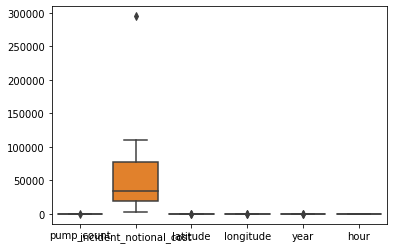

In [53]:
variances = data.groupby([target1]).var()
sns.boxplot(data=variances)

<AxesSubplot:>

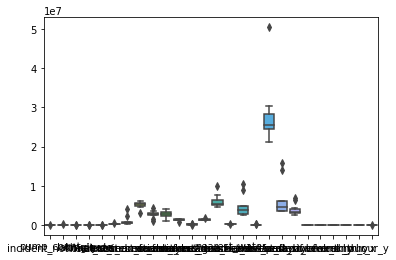

In [55]:
variances = data_enhanced.groupby([target1]).var()
sns.boxplot(data=variances)

<AxesSubplot:>

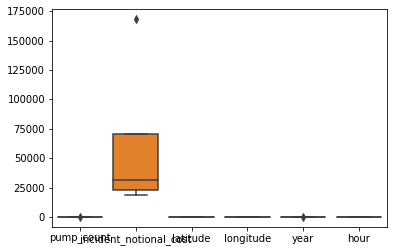

In [56]:
variances = data.groupby([target2]).var()
sns.boxplot(data=variances)

<AxesSubplot:>

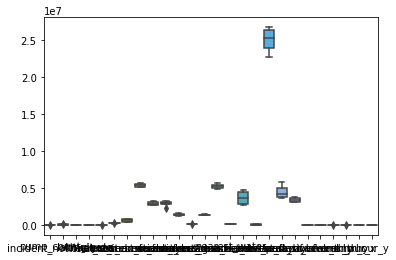

In [57]:
variances = data_enhanced.groupby([target2]).var()
sns.boxplot(data=variances)

##### Naive Bayes 

In [27]:
model_results_nb =  pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_oe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "NB",
                     "",
                     10)
    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'Naive Bayes')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_nb = model_results_nb.append(new_row, ignore_index=True)

Target: animal_group_parent 		Data: initial
Mean accuracy of NB  	: 0.154 	 Standard deviation : 0.022
Target: animal_group_parent 		Data: enhanced
Mean accuracy of NB  	: 0.476 	 Standard deviation : 0.016
Target: animal_group_parent 		Data: selected_features
Mean accuracy of NB  	: 0.463 	 Standard deviation : 0.016
Target: special_service_type_category 		Data: initial
Mean accuracy of NB  	: 0.518 	 Standard deviation : 0.016
Target: special_service_type_category 		Data: enhanced
Mean accuracy of NB  	: 0.508 	 Standard deviation : 0.017
Target: special_service_type_category 		Data: selected_features
Mean accuracy of NB  	: 0.513 	 Standard deviation : 0.017


##### Linear Discriminant Analysis

In [30]:
model_results_LDA = pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_ohe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "LDA",
                     "",
                     10)
    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'Linear Discriminant Analysis')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_LDA = model_results_LDA.append(new_row, ignore_index=True)

Target: animal_group_parent 		Data: initial
Mean accuracy of LDA  	: 0.531 	 Standard deviation : 0.019
Target: animal_group_parent 		Data: enhanced
Mean accuracy of LDA  	: 0.54 	 Standard deviation : 0.018
Target: animal_group_parent 		Data: selected_features
Mean accuracy of LDA  	: 0.551 	 Standard deviation : 0.019
Target: special_service_type_category 		Data: initial
Mean accuracy of LDA  	: 0.594 	 Standard deviation : 0.017
Target: special_service_type_category 		Data: enhanced
Mean accuracy of LDA  	: 0.6 	 Standard deviation : 0.018
Target: special_service_type_category 		Data: selected_features
Mean accuracy of LDA  	: 0.604 	 Standard deviation : 0.017


##### Quadratic Discriminant Analysis

In [31]:
model_results_QDA = pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_ohe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "QDA",
                     "",
                     10)
    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'Quadratic Discriminant Analysis')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_QDA = model_results_QDA.append(new_row, ignore_index=True)

Target: animal_group_parent 		Data: initial


/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminan

Mean accuracy of QDA  	: 0.166 	 Standard deviation : 0.107
Target: animal_group_parent 		Data: enhanced


/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminan

Mean accuracy of QDA  	: 0.069 	 Standard deviation : 0.024
Target: animal_group_parent 		Data: selected_features


/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminan

Mean accuracy of QDA  	: 0.039 	 Standard deviation : 0.006
Target: special_service_type_category 		Data: initial


/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminan

Mean accuracy of QDA  	: 0.368 	 Standard deviation : 0.054
Target: special_service_type_category 		Data: enhanced


/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminan

Mean accuracy of QDA  	: 0.23 	 Standard deviation : 0.11
Target: special_service_type_category 		Data: selected_features


/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.9/site-packages/sklearn/discriminan

Mean accuracy of QDA  	: 0.177 	 Standard deviation : 0.024


#### Random Forest 

##### Selection hyper_params 

In [32]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint


#  we instantiate the random search and fit it like any Scikit-Learn model:
rf = RandomForestClassifier(random_state = 42)

print('Parameters currently in use:\n')
pprint(rf.get_params())


Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [33]:
######## Random Hyperparameter Grid
import pprint

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid


random_grid = { 
                  'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap
               }

print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_ohe, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1400}

- best param for random forest now

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 800}

In [34]:
model_results_rf = pd.DataFrame()

for target in targets:
  for dataframe in dataframes:
    print(f"Target: {target} \t\tData: {dataframe[1]}")
    scores = cross_validation(classification_data[target][dataframe[1]]['X_train_ohe'], 
                     classification_data[target][dataframe[1]]['y_train'],
                     "RF",
                     "",
                     10)
    lgth = scores.shape[0]
    new_row = pd.DataFrame({'method': np.full((lgth, 1), 'Random Forest')[:, 0], 'target': np.full((lgth, 1), target)[:, 0], 'dataframe': np.full((lgth, 1), dataframe[1])[:, 0], 'score': scores})
    model_results_rf = model_results_rf.append(new_row, ignore_index=True)



Target: animal_group_parent 		Data: initial
Mean accuracy of RF  	: 0.564 	 Standard deviation : 0.014
Target: animal_group_parent 		Data: enhanced
Mean accuracy of RF  	: 0.595 	 Standard deviation : 0.01
Target: animal_group_parent 		Data: selected_features
Mean accuracy of RF  	: 0.593 	 Standard deviation : 0.008
Target: special_service_type_category 		Data: initial
Mean accuracy of RF  	: 0.621 	 Standard deviation : 0.012
Target: special_service_type_category 		Data: enhanced
Mean accuracy of RF  	: 0.636 	 Standard deviation : 0.015
Target: special_service_type_category 		Data: selected_features
Mean accuracy of RF  	: 0.635 	 Standard deviation : 0.013


### Plot results

In [35]:
model_results = pd.DataFrame()

model_results = model_results.append(model_results_knn)
model_results = model_results.append(model_results_mlr)
model_results = model_results.append(model_results_LDA)
model_results = model_results.append(model_results_QDA)
model_results = model_results.append(model_results_nb)
model_results = model_results.append(model_results_tree)
model_results = model_results.append(model_results_rf)

model_results.index = list(np.arange((model_results.shape[0])))
model_results

method                         target          dataframe  \
0     K Nearest Neighbor            animal_group_parent            initial   
1     K Nearest Neighbor            animal_group_parent            initial   
2     K Nearest Neighbor            animal_group_parent            initial   
3     K Nearest Neighbor            animal_group_parent            initial   
4     K Nearest Neighbor            animal_group_parent            initial   
...                  ...                            ...                ...   
1255       Random Forest  special_service_type_category  selected_features   
1256       Random Forest  special_service_type_category  selected_features   
1257       Random Forest  special_service_type_category  selected_features   
1258       Random Forest  special_service_type_category  selected_features   
1259       Random Forest  special_service_type_category  selected_features   

         score  
0     0.489865  
1     0.506757  
2     0.493243  
3     0.500000  
4     0.489865  
...        ...  
1255  0.616554  
1256  0.640203  
1257  0.643581  
1258  0.624365  
1259  0.653130  

[1260 rows x 4 columns]

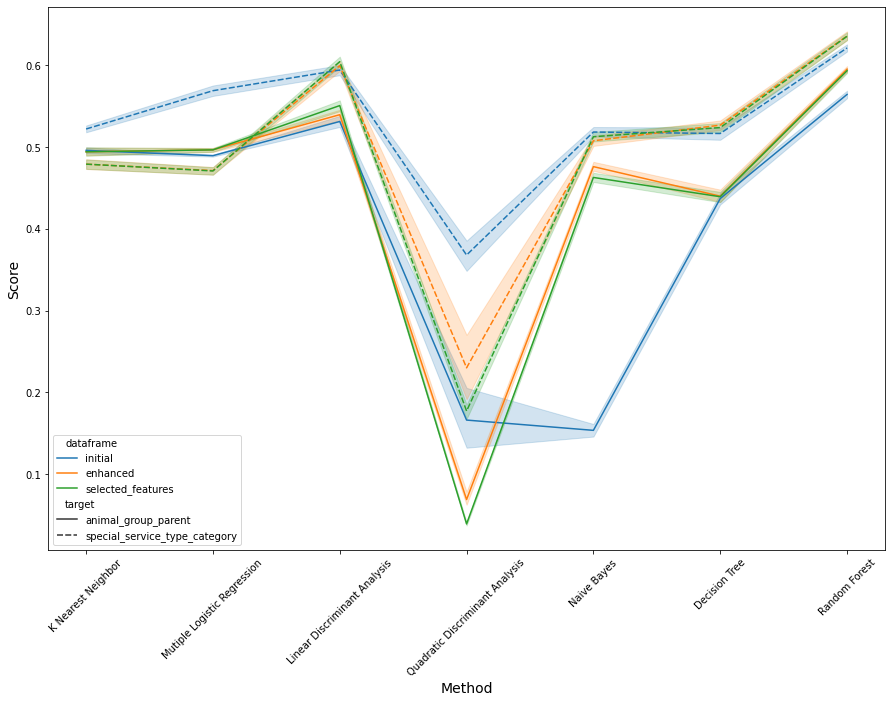

In [36]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.lineplot(ax=ax, data=model_results, x="method", y="score", hue='dataframe', style='target')

ax.set_ylabel('Score', size=14)
ax.set_xlabel('Method', size=14)
ax.tick_params(axis='x', labelrotation=45)